In [1]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns,gap_statistic)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,
                                      plot_subject_trajectories,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel



In [2]:
SEED = 17
os.environ["PYTHONHASHSEED"] = str(SEED)

# לכבות רנדומליות בספריות BLAS/OMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 17


In [3]:


file_path = 'data/q_data/Study_Questionnaire_Responses_October.xlsx'
columns_to_select = ["Subject_Code", "b_questionnaire_completion", "after_questionnaire_completion", "t1_MAAS_date",
                         "t2_PHQ_date", "t3_MAAS_date"]

df = pd.read_excel(file_path)
columns = df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)

selected_df = df.loc[:, columns_to_select]

print("DataFrame with selected columns")
print(f"lines: {selected_df .shape[0]}, columns: {selected_df .shape[1]}")


print("\nהצגת ה-DataFrame החדש (5 השורות הראשונות):")
print(selected_df.head())


the columns in the dataframe:
study_id
Subject_Code
diamond_interview_date
b_diamond_anxiety_phobias_past
b_diamond_Anxiety_phobias_present
b_diamond_ocd_past
b_diamond_ocd_present
b_diamond_adhd_past
b_diamond_adhd_present
b_diamond_depression_past
b_diamond_depression_present
b_diamond_adjustment_past
b_diamond_adjustment_present
b_diamond_ptsd_past
b_diamond_ptsd_present
b_diamond_eating_disorder_past
b_diamond_eating_disorder_present
b_diamond_PMS_past
b_diamond_PMS_present
b_diamond_other_past
b_diamond_other_present
b_diamond_past
b_diamond_present
Dropped_Out_of_Study
Became_Pregnant
Gave_Birth
Dominant_hand
Completed_First_fMRI
Completed_Second_fMRI
Completed_Third_fMRI
b_questionnaire_completion
after_questionnaire_completion
first_fmri_scan_date
second_fmri_scan_date
third_fmri_scan_date
b_questionnaire_and_fmri_days_difference
pregnancy_start_date
b_fmri_and_pregnancy_days_difference
newborn_birth_date
Days_from_Birth_to_Questionnaire_Completion
Demographics_Date
date_of_bir

In [4]:
# see the columns in the dataframe
columns = selected_df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)
phq_columns = ['b_PHQ_1','b_PHQ_2','b_PHQ_3','b_PHQ_4','b_PHQ_5','b_PHQ_6','b_PHQ_7','b_PHQ_8','b_PHQ_9'
                                                                                               ,'b_PHQ_10',
't1_PHQ_1','t1_PHQ_2','t1_PHQ_3','t1_PHQ_4','t1_PHQ_5','t1_PHQ_6','t1_PHQ_7','t1_PHQ_8','t1_PHQ_9','t1_PHQ_10',
               't2_PHQ_1','t2_PHQ_2','t2_PHQ_3','t2_PHQ_4','t2_PHQ_5','t2_PHQ_6','t2_PHQ_7','t2_PHQ_8','t2_PHQ_9','t2_PHQ_10',
               't3_PHQ_1','t3_PHQ_2','t3_PHQ_3','t3_PHQ_4','t3_PHQ_5','t3_PHQ_6','t3_PHQ_7','t3_PHQ_8','t3_PHQ_9','t3_PHQ_10',
               'after_PHQ_1','after_PHQ_2','after_PHQ_3','after_PHQ_4','after_PHQ_5','after_PHQ_6','after_PHQ_7','after_PHQ_8','after_PHQ_9','after_PHQ_10']
gad_columns = ['b_GAD7_1','b_GAD7_2','b_GAD7_3','b_GAD7_4','b_GAD7_5','b_GAD7_6','b_GAD7_7',
               't1_GAD7_1','t1_GAD7_2','t1_GAD7_3','t1_GAD7_4','t1_GAD7_5','t1_GAD7_6','t1_GAD7_7',
               't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7',
               't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7',
               'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']




the columns in the dataframe:
Subject_Code
b_questionnaire_completion
after_questionnaire_completion
t1_MAAS_date
t2_PHQ_date
t3_MAAS_date


In [5]:
df_cleaned = df[['Subject_Code','Dropped_Out_of_Study']+phq_columns+gad_columns]
print(df_cleaned.columns.tolist())

# Remove the subjects who were dropped out of the study
df_filtered = df_cleaned[df_cleaned['Dropped_Out_of_Study'] != 1]

# calculating the number of nan in each column
counts = df_filtered.notna().sum()

# Calculating the percentage of respondents who answered the specific questionnaire out of all respondents
total = len(df_filtered)
percentages = (counts / total * 100)

# creating a new table of number of students and the precentages of the subjects
summary_df = pd.DataFrame([counts, percentages], index=['number of subject', '% of subjects'])


# שמירת הטבלה כקובץ Excel
summary_df.to_excel("data/q_data/5_timepoints/summary_table.xlsx")


['Subject_Code', 'Dropped_Out_of_Study', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_PHQ_10', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_PHQ_10', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_PHQ_10', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_PHQ_10', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_PHQ_10', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3

In [6]:
# הרצה עבור כל סט
export_questionnaire(df_cleaned, 'b', 'data/q_data/5_timepoints/b_questionnaire')
export_questionnaire(df_cleaned, 't1', 'data/q_data/5_timepoints/t1_questionnaire')
export_questionnaire(df_cleaned, 't2', 'data/q_data/5_timepoints/t2_questionnaire')
export_questionnaire(df_cleaned, 't3', 'data/q_data/5_timepoints/t3_questionnaire')
export_questionnaire(df_cleaned, 'after', 'data/q_data/5_timepoints/after_questionnaire')



✅ נוצר הקובץ: data/q_data/5_timepoints/b_questionnaire.csv
📌 מספר נבדקות בקובץ: 141
📋 עמודות שנכללו:
b_PHQ_1, b_PHQ_2, b_PHQ_3, b_PHQ_4, b_PHQ_5, b_PHQ_6, b_PHQ_7, b_PHQ_8, b_PHQ_9, b_PHQ_10, b_GAD7_1, b_GAD7_2, b_GAD7_3, b_GAD7_4, b_GAD7_5, b_GAD7_6, b_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t1_questionnaire.csv
📌 מספר נבדקות בקובץ: 139
📋 עמודות שנכללו:
t1_PHQ_1, t1_PHQ_2, t1_PHQ_3, t1_PHQ_4, t1_PHQ_5, t1_PHQ_6, t1_PHQ_7, t1_PHQ_8, t1_PHQ_9, t1_PHQ_10, t1_GAD7_1, t1_GAD7_2, t1_GAD7_3, t1_GAD7_4, t1_GAD7_5, t1_GAD7_6, t1_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t2_questionnaire.csv
📌 מספר נבדקות בקובץ: 132
📋 עמודות שנכללו:
t2_PHQ_1, t2_PHQ_2, t2_PHQ_3, t2_PHQ_4, t2_PHQ_5, t2_PHQ_6, t2_PHQ_7, t2_PHQ_8, t2_PHQ_9, t2_PHQ_10, t2_GAD7_1, t2_GAD7_2, t2_GAD7_3, t2_GAD7_4, t2_GAD7_5, t2_GAD7_6, t2_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t3_questionnaire.csv
📌 מספר נבדקות בקובץ: 121
📋 עמודות שנכללו:
t3_PHQ_1, t3_PHQ_2, t3_PHQ_3, t3_PHQ_4, t3_PHQ_5, t3_PHQ_6, t3_PHQ_7, t3_PH

In [7]:
q_before = 'data/q_data/5_timepoints/b_questionnaire.csv'
q_t1  = 'data/q_data/5_timepoints/t1_questionnaire.csv'
q_t2 = 'data/q_data/5_timepoints/t2_questionnaire.csv'
q_t3 = 'data/q_data/5_timepoints/t3_questionnaire.csv'
q_after = 'data/q_data/5_timepoints/after_questionnaire.csv'

analyze_questionnaire('b',q_before)
analyze_questionnaire( 't1', q_t1)
analyze_questionnaire( 't2', q_t2)
analyze_questionnaire('t3', q_t3)
analyze_questionnaire( 'after', q_after)



📘 קובץ: data/q_data/5_timepoints/b_questionnaire.csv
👥 נבדקות פעילות: 141
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t1_questionnaire.csv
👥 נבדקות פעילות: 139
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t2_questionnaire.csv
👥 נבדקות פעילות: 132
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t3_questionnaire.csv
👥 נבדקות פעילות: 121
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/after_questionnaire.csv
👥 נבדקות פעילות: 125
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)


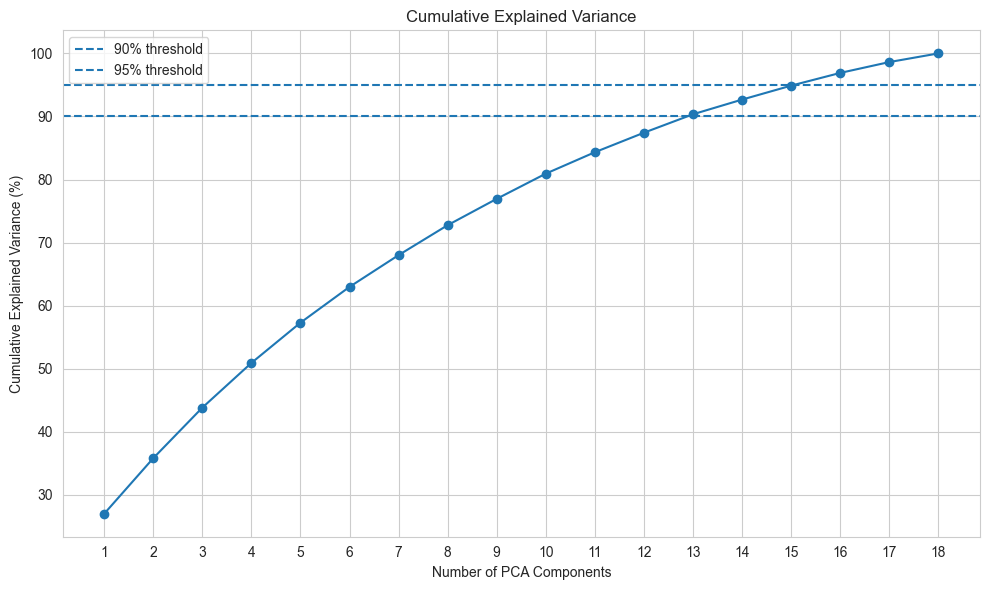

✅ 90% variance: 13 components
✅ 95% variance: 16 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\b_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


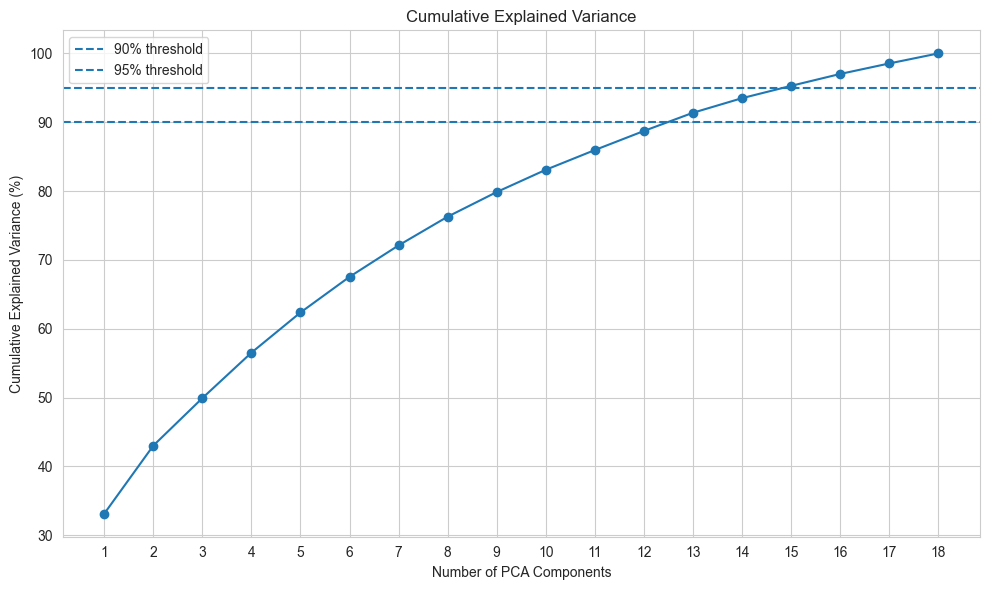

✅ 90% variance: 13 components
✅ 95% variance: 15 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\t1_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


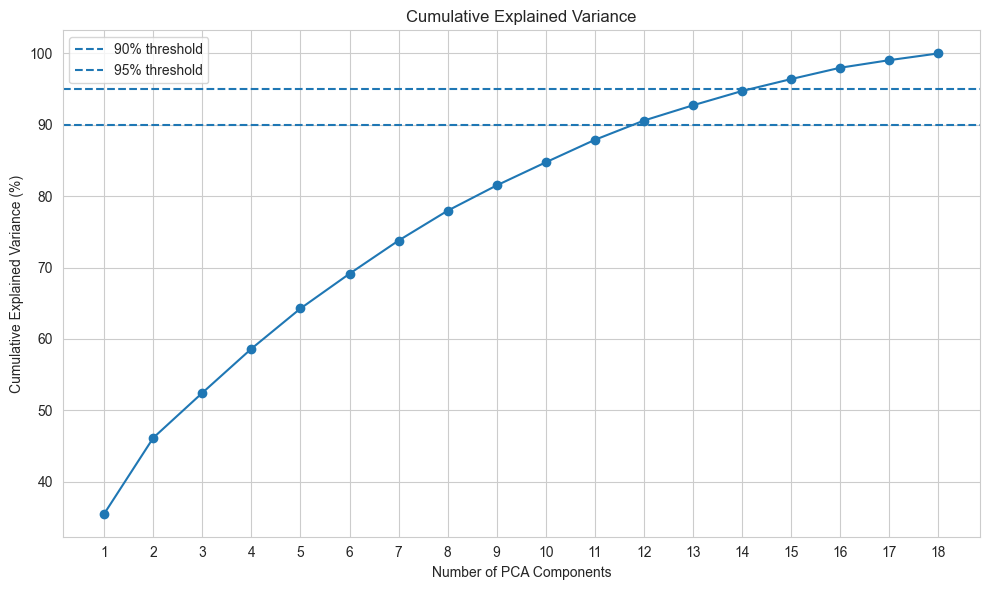

✅ 90% variance: 12 components
✅ 95% variance: 15 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\t2_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


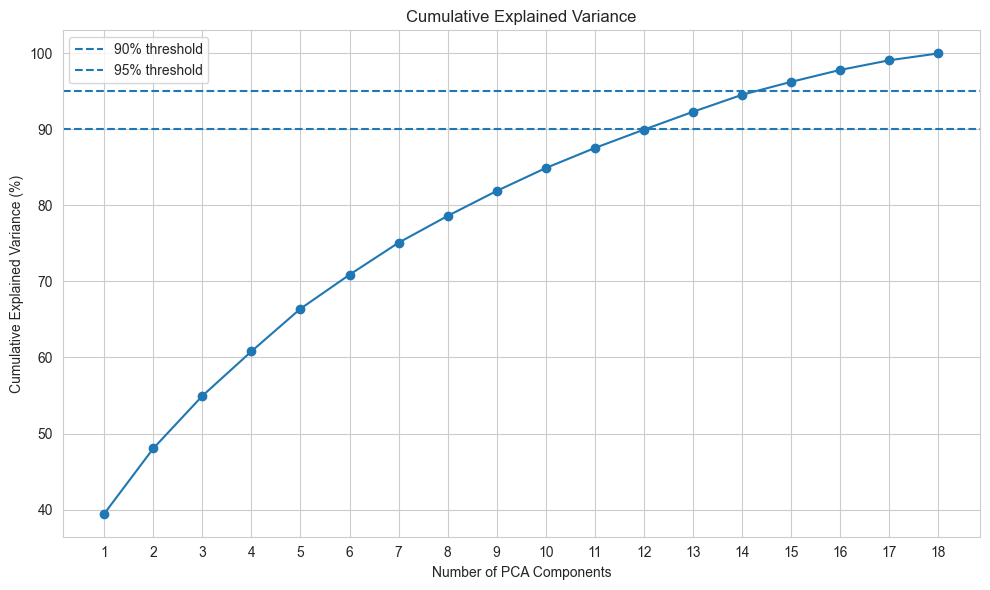

✅ 90% variance: 13 components
✅ 95% variance: 15 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\t3_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


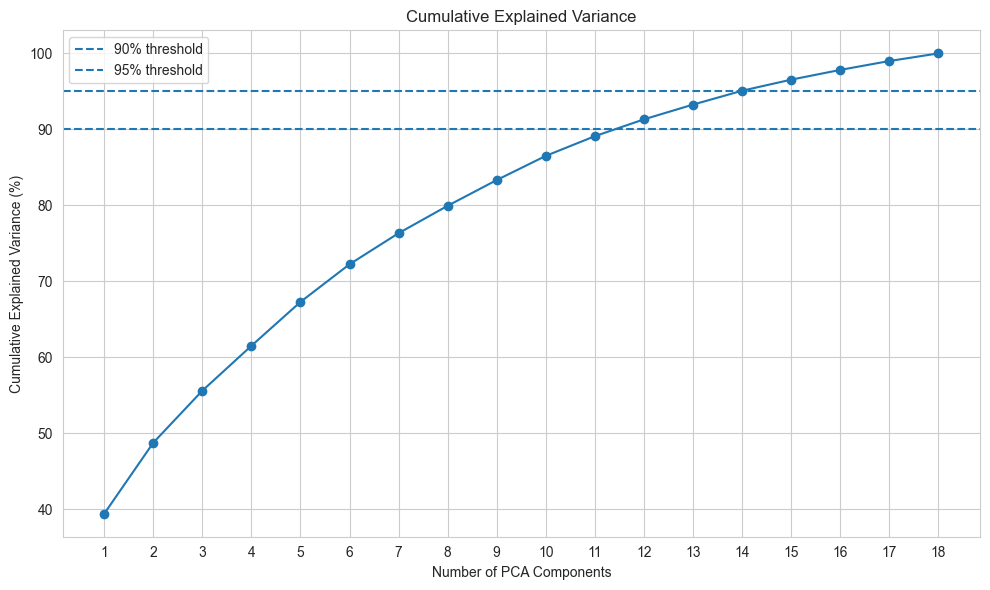

✅ 90% variance: 12 components
✅ 95% variance: 14 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\after_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


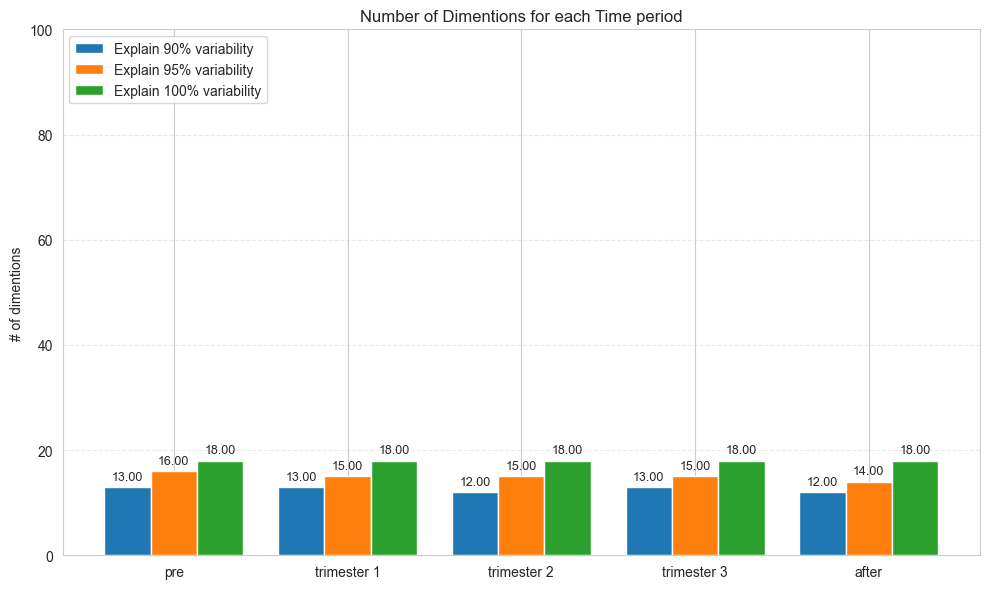

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Number of Dimentions for each Time period'}, ylabel='# of dimentions'>)

In [8]:
n_dims_b_90, n_dims_b_95, n_dims_b_100 = find_optimal_pca_dimensions(q_before,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_b_90}")

n_dims_t1_90, n_dims_t1_95, n_dims_t1_100 = find_optimal_pca_dimensions(q_t1,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t1_90}")

n_dims_t2_90, n_dims_t2_95, n_dims_t2_100 = find_optimal_pca_dimensions(q_t2,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t2_90}")

n_dims_t3_90, n_dims_t3_95, n_dims_t3_100 = find_optimal_pca_dimensions(q_t3,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t3_90}")

n_dims_after_90, n_dims_after_95, n_dims_after_100 = find_optimal_pca_dimensions(q_after,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_after_90}")

groups = ["pre", "trimester 1", "trimester 2", "trimester 3", "after"]
s1 = [n_dims_b_90, n_dims_t1_90, n_dims_t2_90, n_dims_t3_90, n_dims_after_90]  # values for column 1 in each
s2 = [n_dims_b_95, n_dims_t1_95, n_dims_t2_95, n_dims_t3_95, n_dims_after_95]  # values for column 2
s3 = [n_dims_b_100, n_dims_t1_100, n_dims_t2_100, n_dims_t3_100, n_dims_after_100]  # values for column 2

plot_grouped_bars(groups, s1, s2, s3,
                  s1_label="Explain 90% variability",
                  s2_label="Explain 95% variability",
                  s3_label="Explain 100% variability",
                  title="Number of Dimentions for each Time period",
                  ylabel="# of dimentions")



In [9]:
df_b = pd.read_csv(q_before)
df_t1 = pd.read_csv(q_t1)
df_t2 = pd.read_csv(q_t2)
df_t3 = pd.read_csv(q_t3)
df_after =pd.read_csv(q_after)

[[-0.78039029 -1.08835061  0.24264488 ... -0.43612867  0.74874412
  -0.4745889 ]
 [-0.78039029  0.67552796  0.24264488 ... -0.43612867  0.74874412
  -0.4745889 ]
 [-0.78039029 -1.08835061  0.24264488 ... -0.43612867 -0.85084559
  -0.4745889 ]
 ...
 [-0.78039029  0.67552796 -0.97924542 ... -0.43612867  0.74874412
   1.38421761]
 [ 0.63031524 -1.08835061  0.24264488 ...  1.92903065 -0.85084559
  -0.4745889 ]
 [-0.78039029 -1.08835061  0.24264488 ... -0.43612867  0.74874412
  -0.4745889 ]]


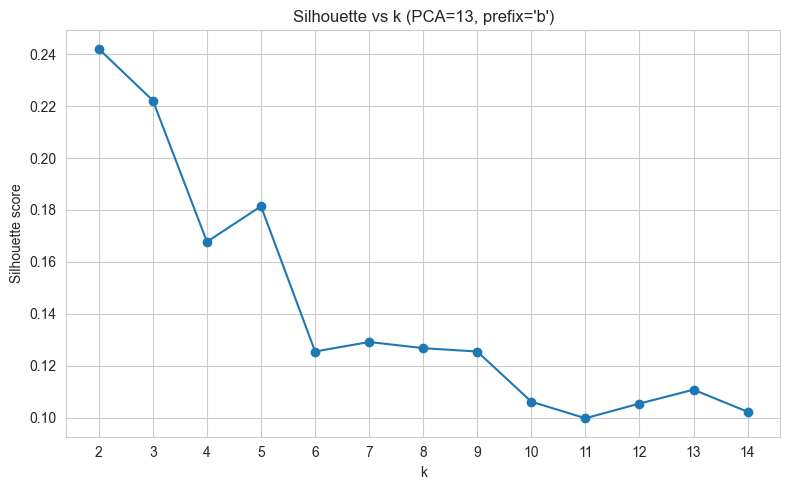


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.240347
1             1        1          -0.074542
2             2        0           0.379985
3             3        1          -0.006045
4             4        1           0.166662
..          ...      ...                ...
136         136        0           0.418431
137         137        0           0.484004
138         138        0           0.215495
139         139        1          -0.080151
140         140        0           0.294669

[141 rows x 3 columns]
[[-0.89022304 -0.84358396 -0.39253684 ... -0.32797823  0.34434645
   0.74773169]
 [-0.89022304  0.48889525 -1.38458447 ... -0.32797823 -0.91523662
   0.74773169]
 [-0.89022304 -0.84358396  0.5995108  ...  2.20474256  0.34434645
  -0.69580587]
 ...
 [ 0.29959429  0.48889525 -0.39253684 ... -0.32797823  0.34434645
   0.74773169]
 [-0.89022304 -0.84358396 -0.39253684 ... -0.32797823 -0.91523662
  -0.69580587]


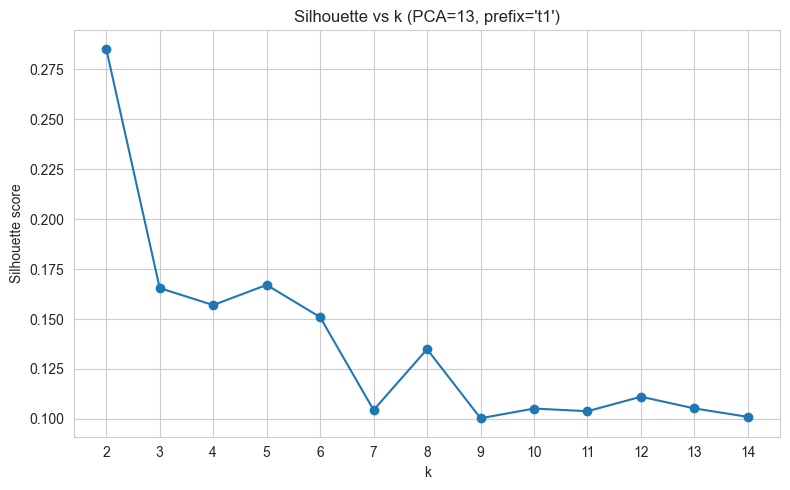


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        1           0.358476
1             1        1           0.478454
2             2        0          -0.051484
3             3        0           0.065141
4             4        1           0.446021
..          ...      ...                ...
134         134        1           0.471002
135         135        1           0.405437
136         136        1           0.292711
137         137        1           0.506515
138         138        1           0.205346

[139 rows x 3 columns]
[[-0.76762364 -0.87089026  0.82435934 ... -0.33571839  0.53520153
  -0.74530381]
 [-0.76762364 -0.87089026 -1.3304017  ... -0.33571839  1.89379003
  -0.74530381]
 [-0.76762364 -0.87089026  1.90173986 ...  1.99664095  0.53520153
  -0.74530381]
 ...
 [-0.76762364 -0.87089026 -0.25302118 ... -0.33571839 -0.82338697
  -0.74530381]
 [ 0.65950764  0.51414004  0.82435934 ... -0.33571839  0.53520153
   0.68049479]


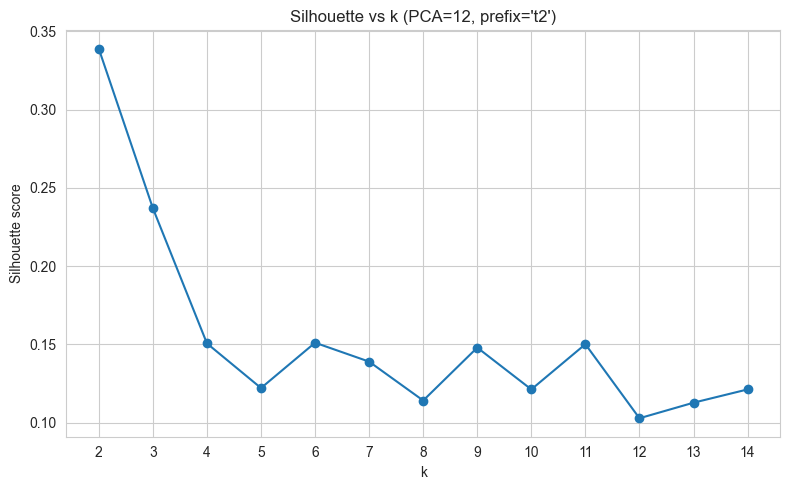


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.389987
1             1        0           0.381024
2             2        0           0.176649
3             3        1           0.058876
4             4        0           0.408814
..          ...      ...                ...
127         127        1          -0.055087
128         128        0           0.421859
129         129        0           0.571852
130         130        1           0.123550
131         131        0           0.563692

[132 rows x 3 columns]
[[-0.72168784  0.69337525  0.54069784 ... -0.31446782  0.50096476
  -0.65653216]
 [-0.72168784 -0.83205029  1.57918099 ... -0.31446782 -0.78875302
  -0.65653216]
 [ 0.8660254   0.69337525  1.57918099 ...  2.40343263 -0.78875302
  -0.65653216]
 ...
 [-0.72168784  0.69337525 -1.53626847 ... -0.31446782  0.50096476
  -0.65653216]
 [ 0.8660254   0.69337525  1.57918099 ... -0.31446782  0.50096476
  -0.65653216]


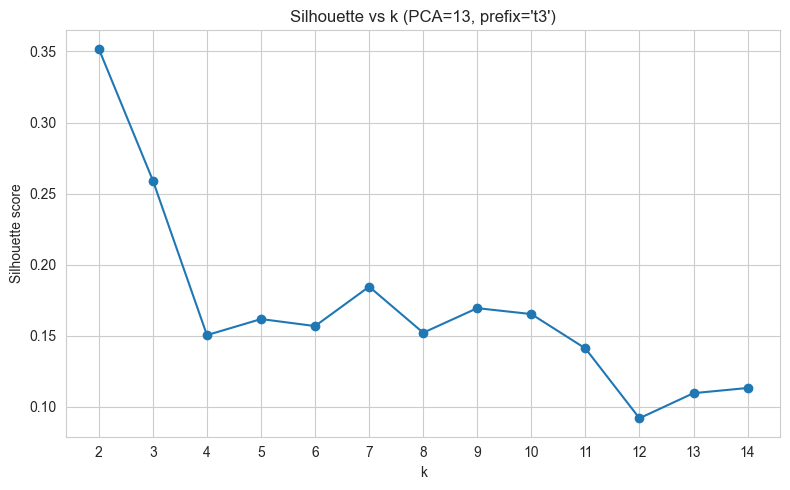


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.353085
1             1        0           0.476341
2             2        1           0.048104
3             3        1           0.255746
4             4        0           0.517052
..          ...      ...                ...
116         116        0           0.217884
117         117        0           0.329736
118         118        0           0.251735
119         119        0           0.275199
120         120        0           0.535732

[121 rows x 3 columns]
[[-0.61965161  0.49201574  0.27313539 ... -0.27702412  0.3352392
  -0.708583  ]
 [ 0.89910233  0.49201574  0.27313539 ... -0.27702412 -0.86204366
  -0.708583  ]
 [-0.61965161  0.49201574 -0.79379974 ... -0.27702412 -0.86204366
  -0.708583  ]
 ...
 [-0.61965161  0.49201574  0.27313539 ... -0.27702412  0.3352392
  -0.708583  ]
 [ 2.41785627  3.49211175  2.40700566 ... -0.27702412  0.3352392
   2.14860651]
 [ 

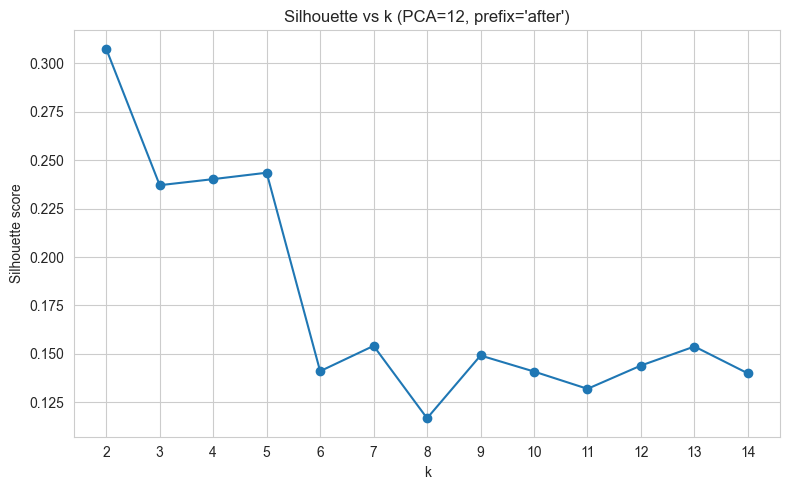


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        1           0.327705
1             1        0          -0.137149
2             2        1           0.427279
3             3        0          -0.020914
4             4        1           0.497180
..          ...      ...                ...
120         120        1           0.477516
121         121        1           0.344513
122         122        1           0.476640
123         123        0           0.221218
124         124        0          -0.063514

[125 rows x 3 columns]


In [10]:
res_b = pca_kmeans_minimal_outputs(
    df_b,
    prefix="b",
    n_components=n_dims_b_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/5_timepoints"
)


# You already found that e.g., 22 PCA components explain 95% of variance
res_t1 = pca_kmeans_minimal_outputs(
    df_t1,
    prefix="t1",
    n_components=n_dims_t1_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/5_timepoints"
)


# Load your Excel file

# You already found that e.g., 22 PCA components explain 95% of variance
res_t2 = pca_kmeans_minimal_outputs(
    df_t2,
    prefix="t2",
    n_components=n_dims_t2_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/5_timepoints")


# You already found that e.g., 22 PCA components explain 95% of variance
res_t3 = pca_kmeans_minimal_outputs(
    df_t3,
    prefix="t3",
    n_components=n_dims_t3_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/5_timepoints")


# You already found that e.g., 22 PCA components explain 95% of variance
res_after = pca_kmeans_minimal_outputs(
    df_after,
    prefix="after",
    n_components=n_dims_after_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir= "data/only_Q_outputs/5_timepoints")

In [11]:
sil_scores_b = res_b["sil_scores"]
print("k* =", res_b["best_k"])

sil_scores_t1 = res_t1["sil_scores"]
print("k* =", res_t1["best_k"])

sil_scores_t2 = res_t2["sil_scores"]
print("k* =", res_t2["best_k"])

sil_scores_t3 = res_t3["sil_scores"]
print("k* =", res_t3["best_k"])

sil_scores_after = res_after["sil_scores"]
print("k* =", res_after["best_k"])

ks = list(range(2, 15))  # same k_range you used in the runs

sil_b = res_b["sil_scores"].iloc[:, 0].values
sil_t1 = res_t1["sil_scores"].iloc[:, 0].values
sil_t2 = res_t2["sil_scores"].iloc[:, 0].values
sil_t3 = res_t3["sil_scores"].iloc[:, 0].values
sil_after = res_after["sil_scores"].iloc[:, 0].values

best_k_b_sil = res_b["best_k"]
best_k_t1_sil = res_t1["best_k"]
best_k_t2_sil = res_t2["best_k"]
best_k_t3_sil = res_t3["best_k"]
best_k_after_sil = res_after["best_k"]

k* = 2
k* = 2
k* = 2
k* = 2
k* = 2


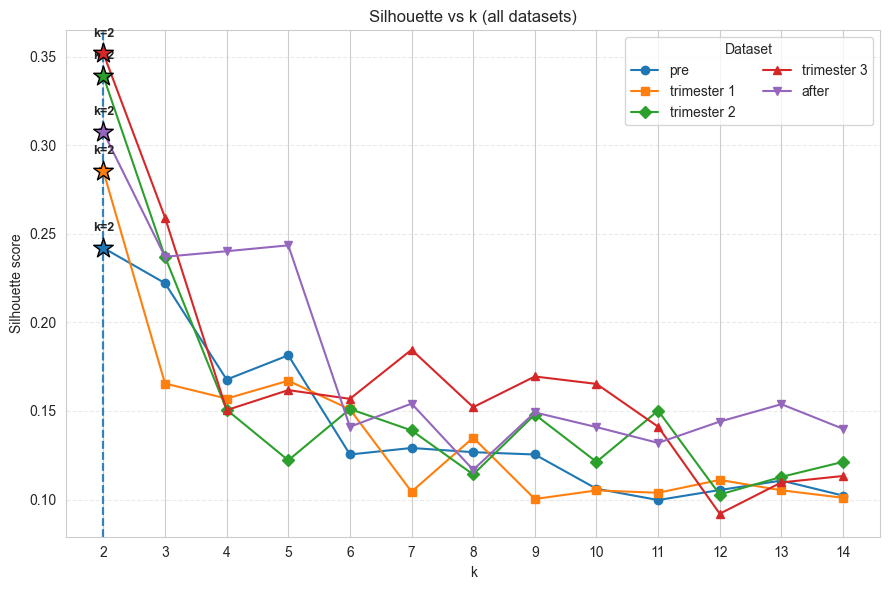

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))

datasets = [
    ("pre", sil_b, best_k_b_sil, 'o'),
    ("trimester 1", sil_t1, best_k_t1_sil, 's'),
    ("trimester 2", sil_t2, best_k_t2_sil, 'D'),
    ("trimester 3", sil_t3, best_k_t3_sil, '^'),
    ("after", sil_after, best_k_after_sil, 'v'),
]

for name, sil, best_k, m in datasets:
    ax.plot(ks, sil, marker=m, label=f"{name}")
    # highlight the chosen k: star + vertical line + label
    i = ks.index(best_k)
    y = sil[i]
    ax.scatter([best_k], [y], s=220, marker='*', edgecolors='black', zorder=5)
    ax.axvline(best_k, linestyle='--', alpha=0.35)
    ax.annotate(f"k={best_k}", xy=(best_k, y),
                xytext=(0, 10), textcoords="offset points",
                ha="center", va="bottom", fontsize=9, weight="bold")

ax.set_title("Silhouette vs k (all datasets)")
ax.set_xlabel("k")
ax.set_ylabel("Silhouette score")
ax.set_xticks(ks)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend(title="Dataset", ncol=2)
plt.tight_layout()
plt.show()

In [13]:

# Run gap statistic on the filtered DataFrame
# results_after_gap, best_k_after_gap = gap_statistic((df_after.drop(columns=["Subject_Code"])).values,
#                                 n_refs=50,
#                                 k_min=2,
#                                 max_clusters=15,
#                                 random_state=42)
# # Run gap statistic on the filtered DataFrame
# results_b_gap, best_k_b_gap = gap_statistic((df_b.drop(columns=["Subject_Code"])).values,
#                                 n_refs=50,k_min=2,
#                                 # max_clusters=15,
#                                 random_state=42)

# # Run gap statistic on the filtered DataFrame
# results_t1_gap, best_k_t1_gap = gap_statistic((df_t1.drop(columns=["Subject_Code"])).values,
#                                 n_refs=50,k_min=2,
#                                 max_clusters=15,
#                                 random_state=42)
#
# results_t2_gap, best_k_t2_gap = gap_statistic((df_t2.drop(columns=["Subject_Code"])).values,
#                                 n_refs=50,k_min=2,
#                                 max_clusters=15,
#                                 random_state=42)
#
#
# # Run gap statistic on the filtered DataFrame
# results_t3_gap, best_k_t3_gap = gap_statistic((df_t3.drop(columns=["Subject_Code"])).values,
#                                 n_refs=50,k_min=2,
#                                 max_clusters=15,
#                                 random_state=42)




In [14]:
# ks_b   = results_b_gap["k"].values
# gaps_b = results_b_gap["gap"].values
# sks_b  = results_b_gap["sk"].values
#
# ks_t1   = results_t1_gap["k"].values
# gaps_t1 = results_t1_gap["gap"].values
# sks_t1  = results_t1_gap["sk"].values
#
# ks_t2   = results_t2_gap["k"].values
# gaps_t2 = results_t2_gap["gap"].values
# sks_t2  = results_t2_gap["sk"].values
#
# ks_t3   = results_t3_gap["k"].values
# gaps_t3 = results_t3_gap["gap"].values
# sks_t3  = results_t3_gap["sk"].values
#
# ks_after   = results_after_gap["k"].values
# gaps_after = results_after_gap["gap"].values
# sks_after  = results_after_gap["sk"].values
#
# fig, ax = plt.subplots(figsize=(9, 6))
#
# datasets = [
#     ("pre", ks_b, gaps_b, sks_b, best_k_b_gap),
#     ("t1", ks_t1, gaps_t1, sks_t1, best_k_t1_gap),
#     ("t2", ks_t2, gaps_t2, sks_t2, best_k_t2_gap),
#     ("t3", ks_t3, gaps_t3, sks_t3, best_k_t3_gap),
#     ("post", ks_after, gaps_after, sks_after, best_k_after_gap)
# ]
#
# for name, ks, gaps, sks, best_k in datasets:
#     # Plot gap curve with error bars
#     ax.errorbar(ks, gaps, yerr=sks, capsize=4, label=f"{name}")
#
#     # Mark best_k with a larger star-shaped marker in red
#     best_idx = ks.tolist().index(best_k)
#     ax.scatter(ks[best_idx], gaps[best_idx],
#                s=200, marker='*', edgecolors='black', zorder=5)
#
#     # Annotate the chosen k above the point
#     ax.annotate(f"k={best_k}",
#                 xy=(ks[best_idx], gaps[best_idx]),
#                 xytext=(0, 10), textcoords="offset points",
#                 ha='center', va='bottom', fontsize=9, weight='bold')
#
# ax.set_xlabel("Number of clusters (k)")
# ax.set_ylabel("Gap(k)")
# ax.set_title("Gap Statistic Curves")
# ax.grid(True, axis='y', linestyle='--', alpha=0.4)
# ax.legend(title="Dataset", ncol=2)
# plt.tight_layout()
# plt.show()


Cluster assignments saved to data/only_Q_outputs/5_timepoints/clusters_before.csv
PC1 values saved to data/only_Q_outputs/5_timepoints/pc1/before_data.csv


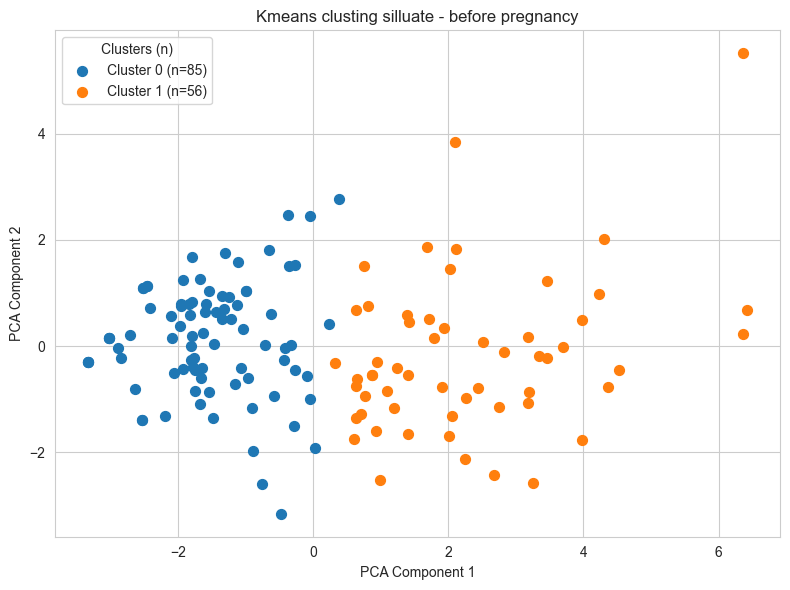

Cluster assignments saved to data/only_Q_outputs/5_timepoints/clusters_t1.csv
PC1 values saved to data/only_Q_outputs/5_timepoints/pc1/t1_data.csv


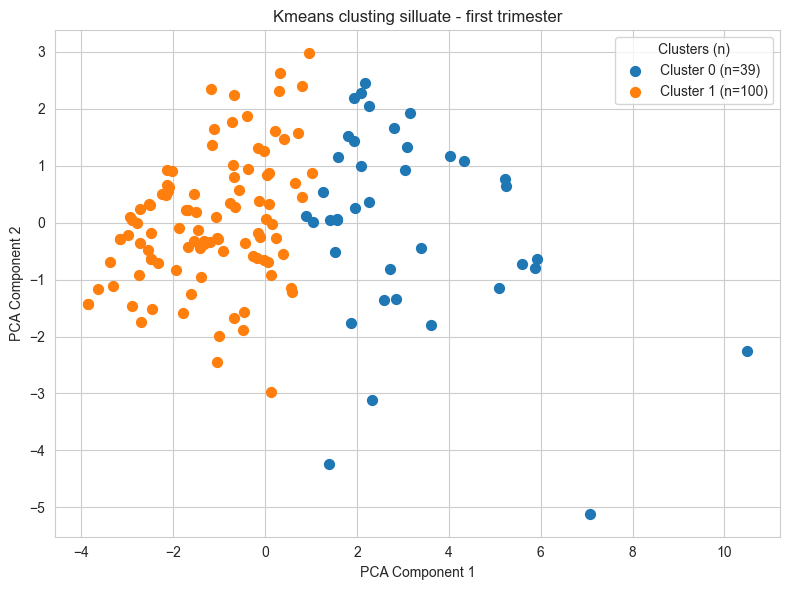

Cluster assignments saved to data/only_Q_outputs/5_timepoints/clusters_t2.csv
PC1 values saved to data/only_Q_outputs/5_timepoints/pc1/t2_data.csv


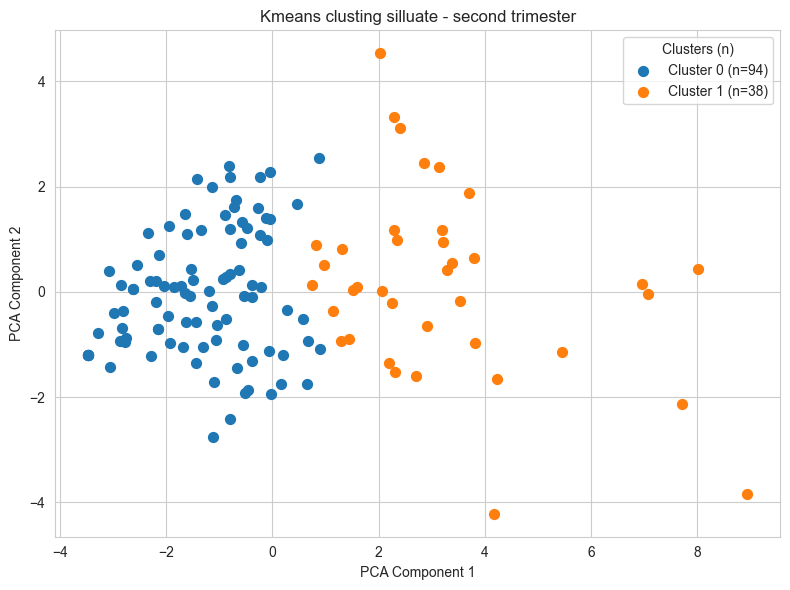

Cluster assignments saved to data/only_Q_outputs/5_timepoints/clusters_t3.csv
PC1 values saved to data/only_Q_outputs/5_timepoints/pc1/t3_data.csv


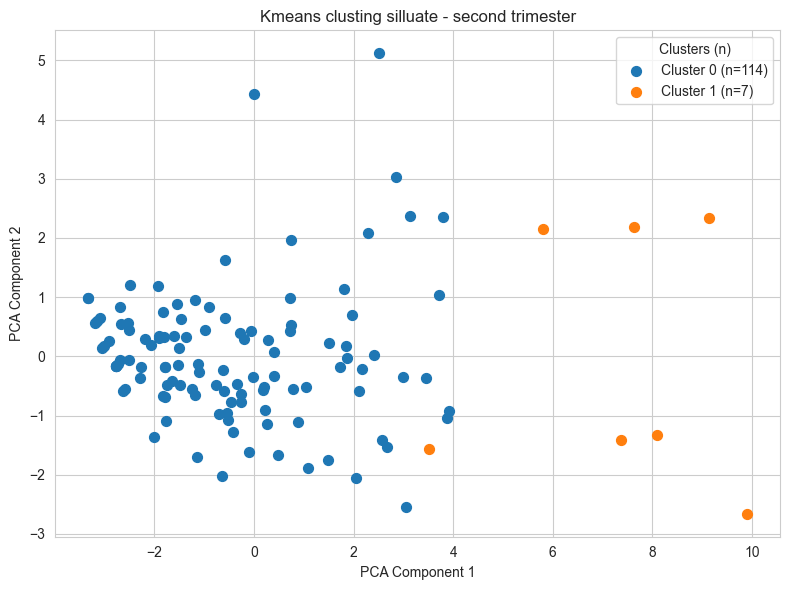

Cluster assignments saved to data/only_Q_outputs/5_timepoints/clusters_after.csv
PC1 values saved to data/only_Q_outputs/5_timepoints/pc1/after_data.csv


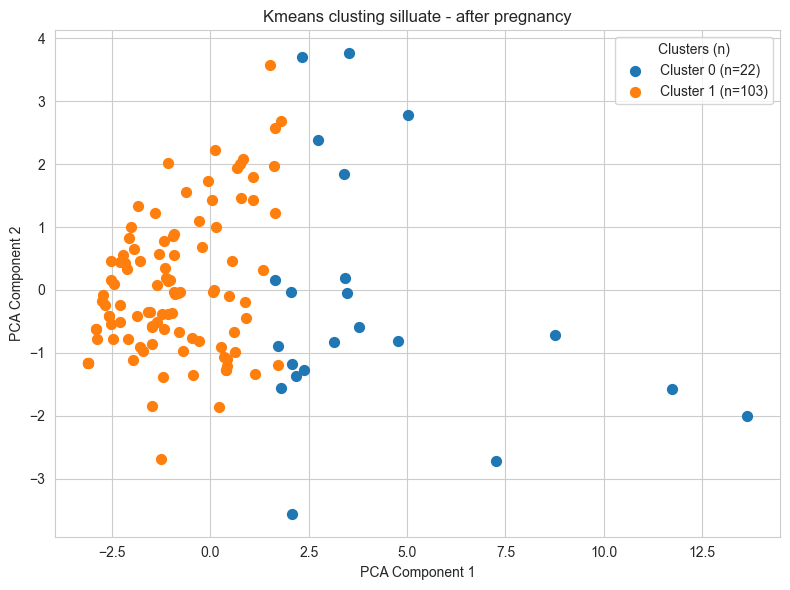

In [15]:
import os
labels_b_sil, data_pca_b_sil, model_b_sil, pca_b_sil = run_kmeans_clustering(
    df=df_b,
    prefix="b",  # your prefix
    n_components=n_dims_b_90,
    k=best_k_b_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - before pregnancy",
    csv_path="data/only_Q_outputs/5_timepoints/clusters_before.csv",
    pc1_csv_path = 'data/only_Q_outputs/5_timepoints/pc1/before_data.csv')

labels_t1_sil, data_pca_t1_sil, model_t1_sil, pca_t1 = run_kmeans_clustering(
    df=df_t1,
    prefix="t1",  # your prefix
    n_components=n_dims_t1_90,
    k=best_k_t1_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - first trimester",
    csv_path="data/only_Q_outputs/5_timepoints/clusters_t1.csv",
    pc1_csv_path = 'data/only_Q_outputs/5_timepoints/pc1/t1_data.csv'
)

labels_t2_sil, data_pca_t2_sil, model_t2_sil, pca_t2 = run_kmeans_clustering(
    df=df_t2,
    prefix="t2",  # your prefix
    n_components=n_dims_t2_90,
    k=best_k_t2_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - second trimester",
    csv_path="data/only_Q_outputs/5_timepoints/clusters_t2.csv",
    pc1_csv_path = 'data/only_Q_outputs/5_timepoints/pc1/t2_data.csv'
)

labels_t3_sil, data_pca_t3_sil, model_t3_sil, pca_t3 = run_kmeans_clustering(
    df=df_t3,
    prefix="t3",  # your prefix
    n_components=n_dims_t3_90,
    k=best_k_t3_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - second trimester",
    csv_path="data/only_Q_outputs/5_timepoints/clusters_t3.csv",
    pc1_csv_path = 'data/only_Q_outputs/5_timepoints/pc1/t3_data.csv'
)

labels_after_sil, data_pca_after_sil, model_after_sil, pca_after = run_kmeans_clustering(
    df=df_after,
    prefix="after",  # your prefix
    n_components=n_dims_after_90,
    k=best_k_after_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - after pregnancy",
    csv_path="data/only_Q_outputs/5_timepoints/clusters_after.csv",
    pc1_csv_path = 'data/only_Q_outputs/5_timepoints/pc1/after_data.csv'
)

C:\Users\nogag\PycharmProjects\technion\vizualizations_functions.py:524: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


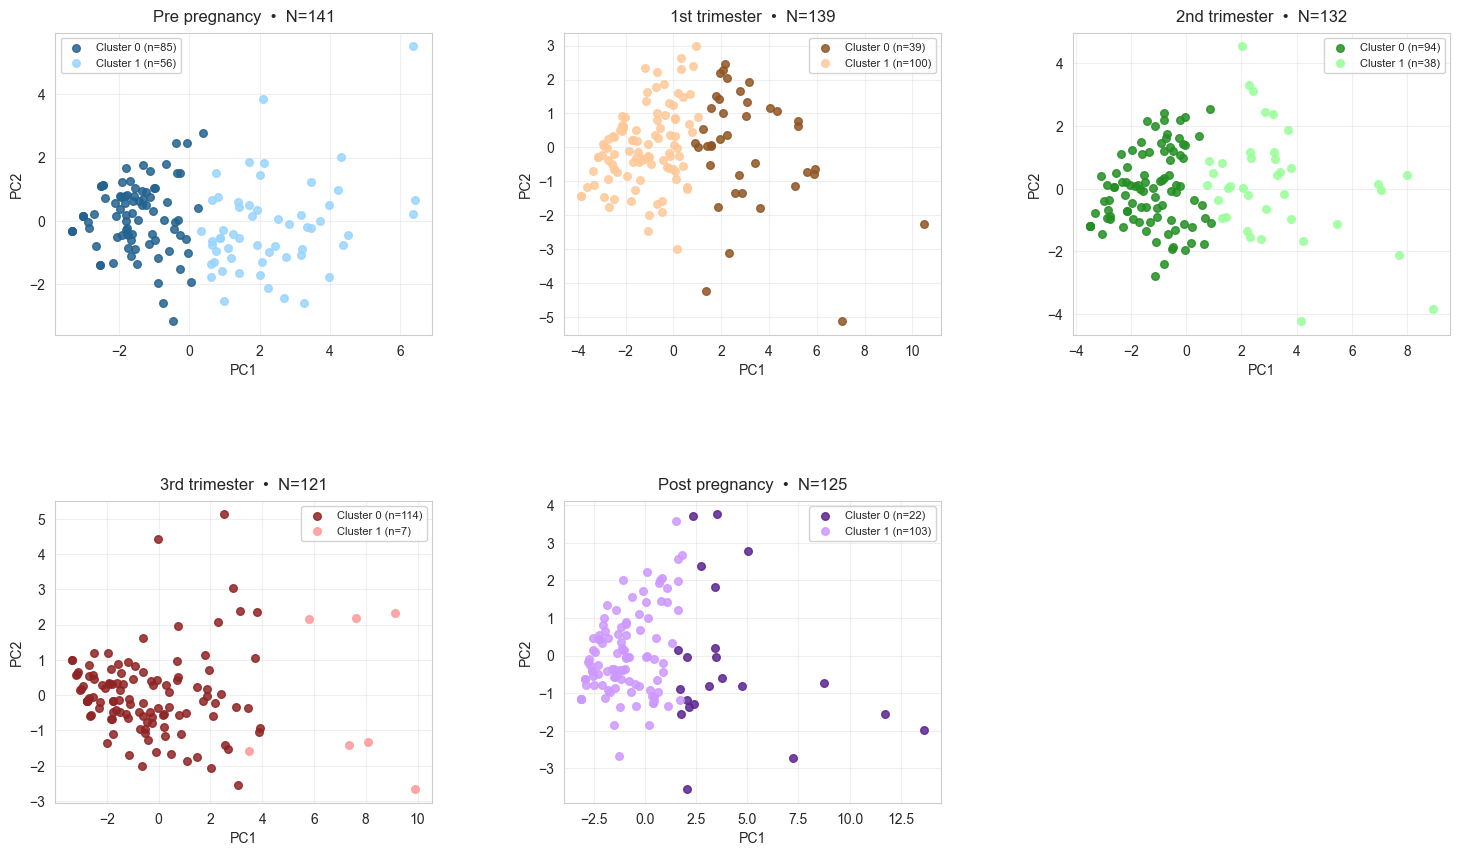

In [16]:
plot_multi_dataset_scatters_colored(
    datasets=[data_pca_b_sil, data_pca_t1_sil, data_pca_t2_sil, data_pca_t3_sil, data_pca_after_sil],
    titles=["Pre pregnancy", "1st trimester", "2nd trimester", "3rd trimester", "Post pregnancy"],
    labels_list=[labels_b_sil, labels_t1_sil, labels_t2_sil, labels_t3_sil, labels_after_sil],
    x_idx=0, y_idx=1,
    base_colors=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"],
    show_counts=True,  # <-- on
    show_percent=False  # <-- optional %
)

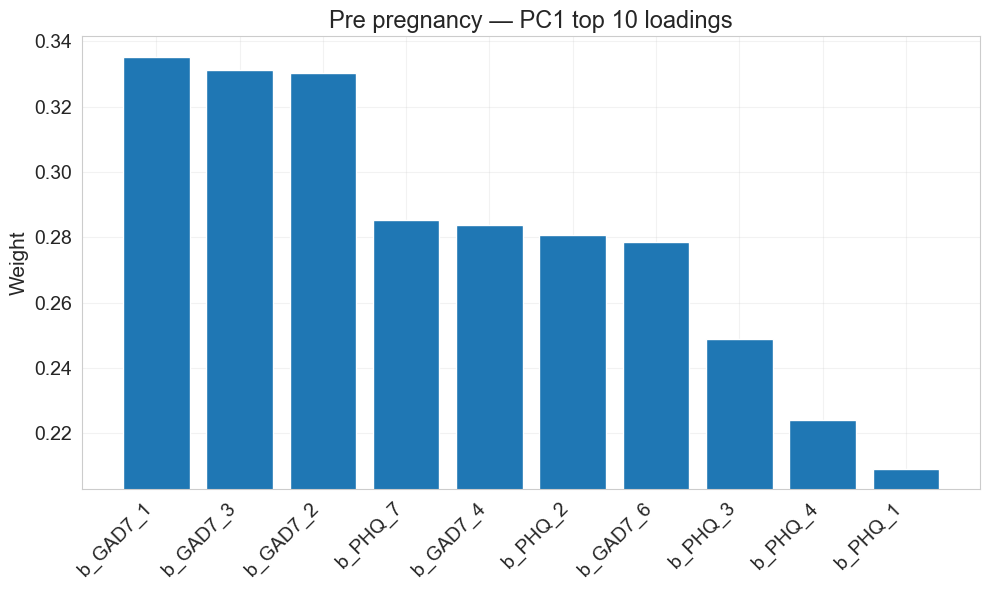

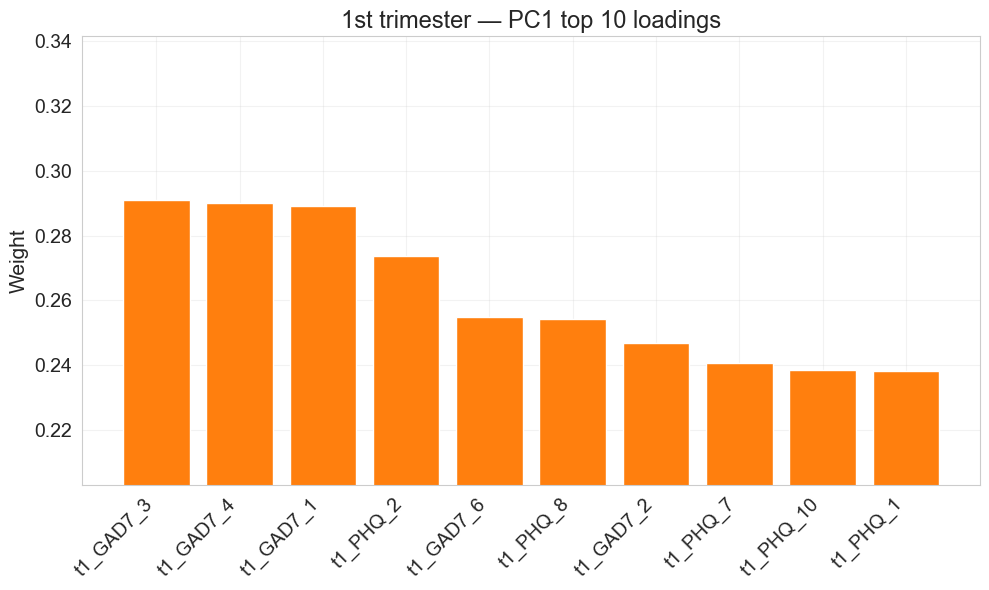

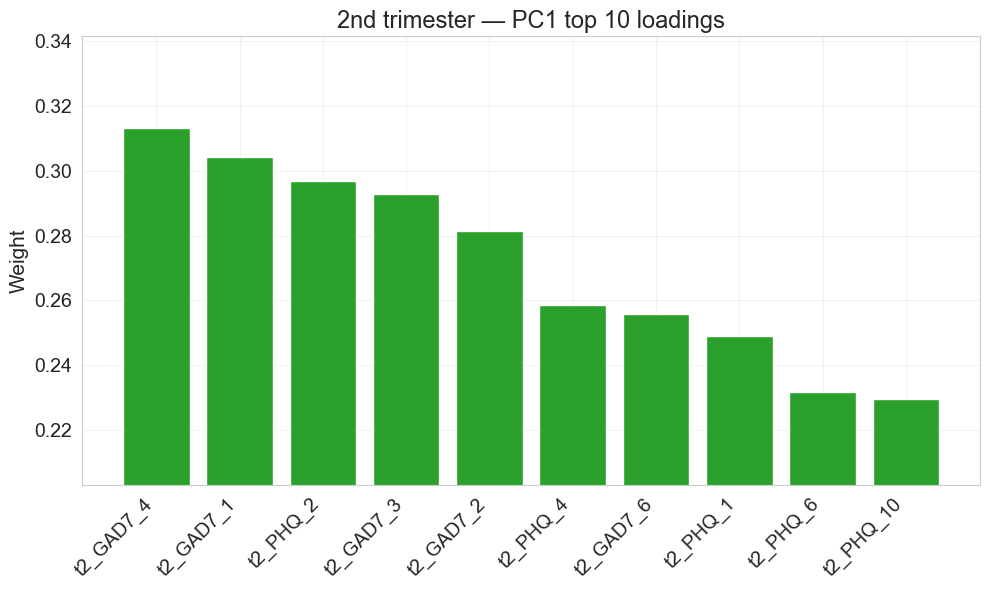

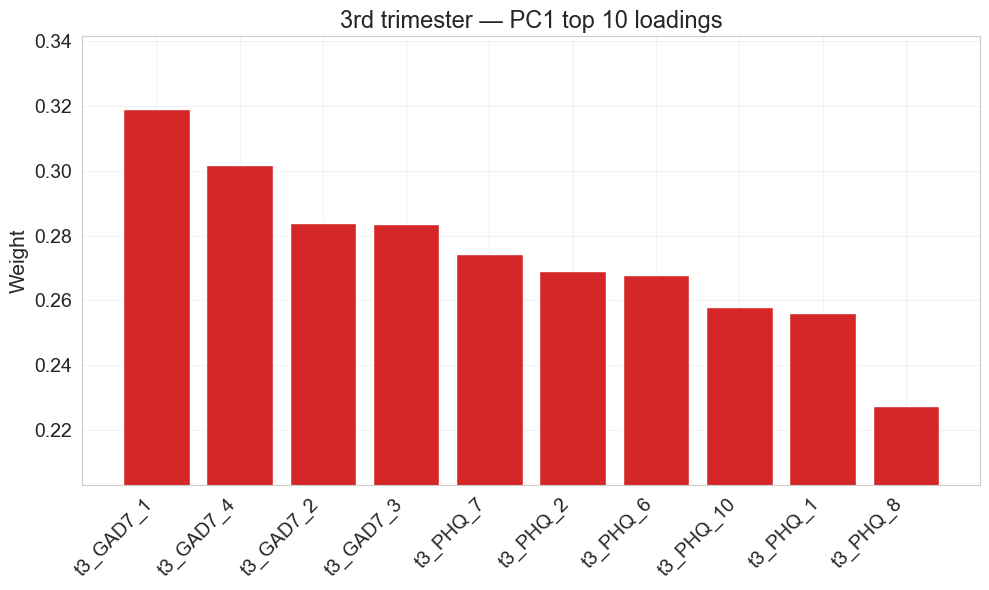

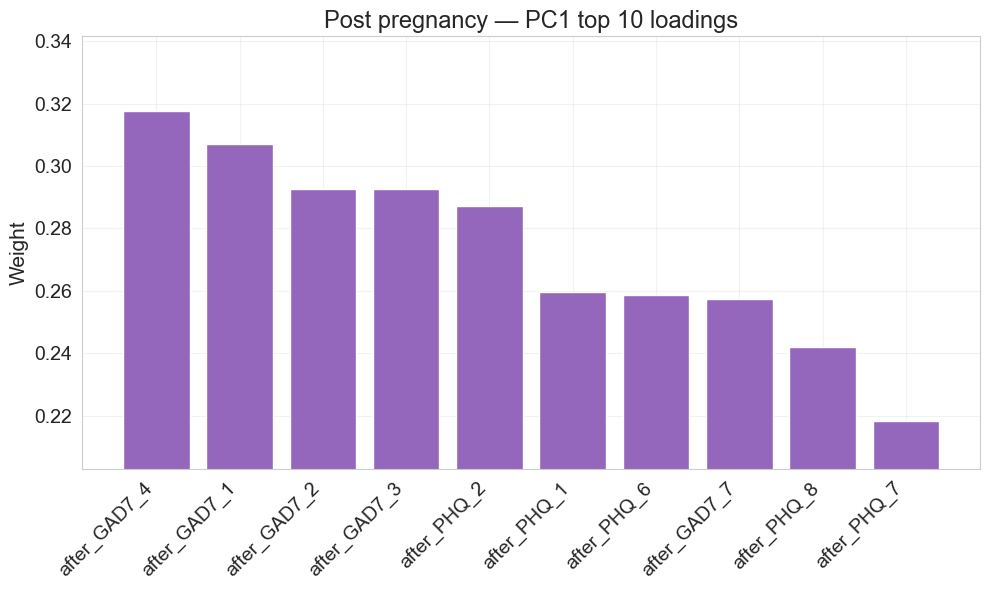

         dataset  pc  rank_within_dataset    feature   loading  abs_loading
0  1st trimester   1                    1  t1_GAD7_3  0.291004     0.291004
1  1st trimester   1                    2  t1_GAD7_4  0.290032     0.290032
2  1st trimester   1                    3  t1_GAD7_1  0.289002     0.289002
3  1st trimester   1                    4   t1_PHQ_2  0.273640     0.273640
4  1st trimester   1                    5  t1_GAD7_6  0.254839     0.254839
5  1st trimester   1                    6   t1_PHQ_8  0.254185     0.254185
6  1st trimester   1                    7  t1_GAD7_2  0.246927     0.246927
7  1st trimester   1                    8   t1_PHQ_7  0.240688     0.240688
8  1st trimester   1                    9  t1_PHQ_10  0.238631     0.238631
9  1st trimester   1                   10   t1_PHQ_1  0.238317     0.238317


In [17]:
# PC1 (pc_index=0), top 15:
df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_b_sil, pca_t1, pca_t2, pca_t3, pca_after],
    dfs=[df_b, df_t1, df_t2, df_t3, df_after],
    prefixes=["b", "t1", "t2", "t3", "after"],
    titles=["Pre pregnancy", "1st trimester", "2nd trimester", "3rd trimester", "Post pregnancy"],
    pc_index=0,
    top_n=10,
    figsize=(10, 6),
    fontsize=15,
    save_csv_path="data/only_Q_outputs/5_timepoints/top_loadings_PC1.csv"  # או "top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

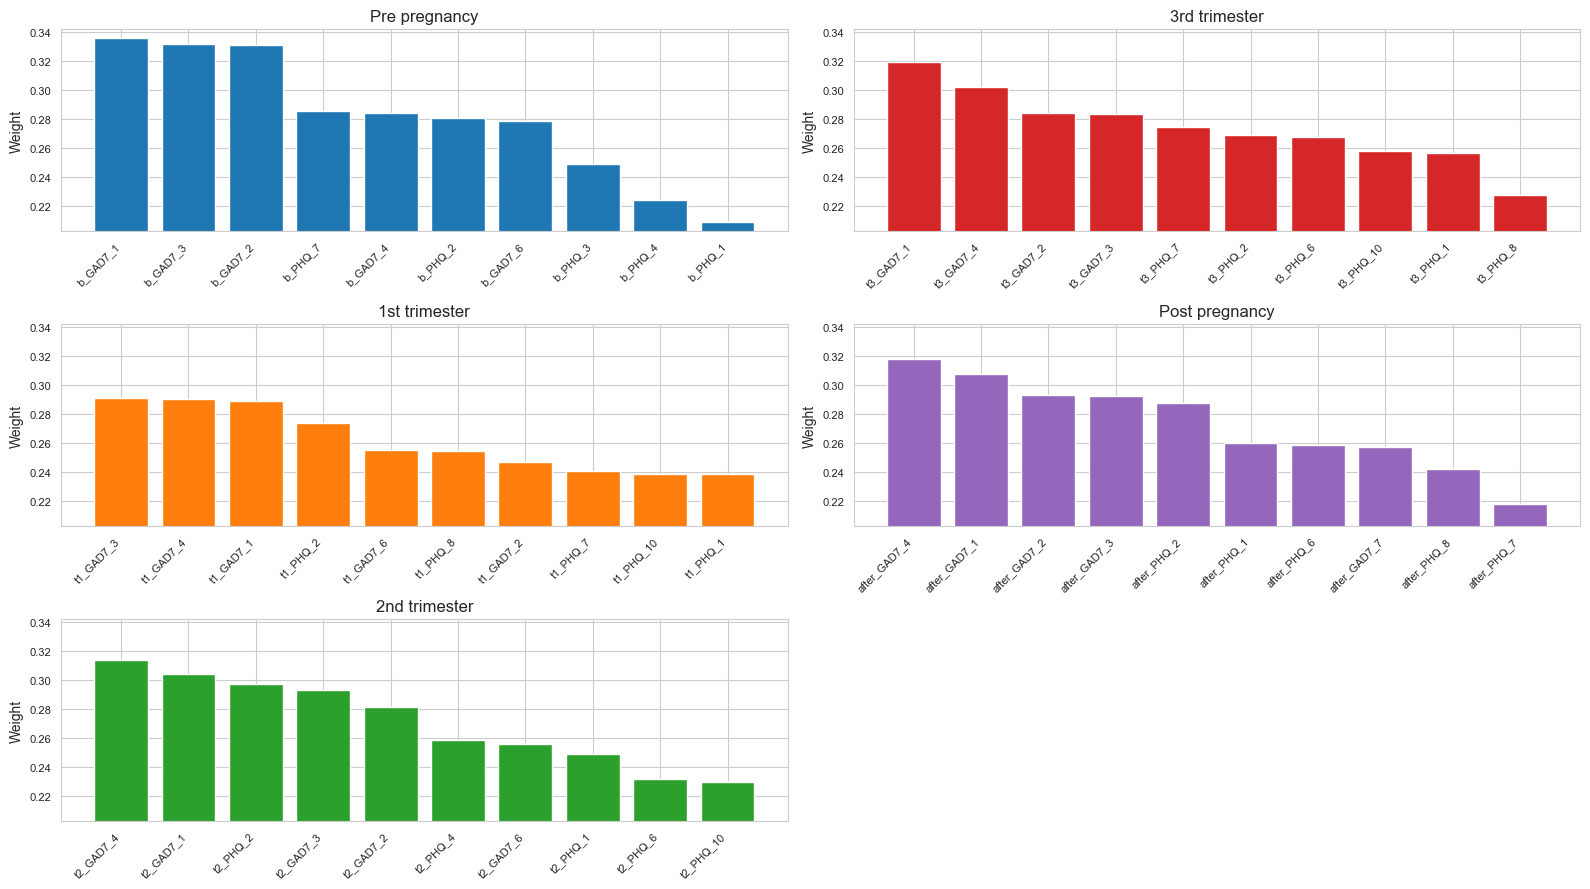

In [18]:
plot_pca_weights_two_cols_split(
    pcas=[pca_b_sil, pca_t1, pca_t2, pca_t3, pca_after],
    dfs=[df_b, df_t1, df_t2, df_t3, df_after],
    prefixes=["b", "t1", "t2", "t3", "after"],
    titles=["Pre pregnancy", "1st trimester", "2nd trimester", "3rd trimester", "Post pregnancy"],
    pc_index=0,
    top_n=10,
    figsize=(16, 9),
    fontsize=10
)

In [19]:
# Map each file to the column name you want in the merged table
files = {
    "data/only_Q_outputs/5_timepoints/clusters_before.csv": "before",
    "data/only_Q_outputs/5_timepoints/clusters_t1.csv": "t1",
    "data/only_Q_outputs/5_timepoints/clusters_t2.csv": "t2",
    "data/only_Q_outputs/5_timepoints/clusters_t3.csv": "t3",
    "data/only_Q_outputs/5_timepoints/clusters_after.csv": "after",
}


# Load and prepare all dataframes
dfs = [load_one(path, col) for path, col in files.items()]

# Outer-join on Subject_Code
merged = reduce(lambda left, right: pd.merge(left, right, on="Subject_Code", how="outer"), dfs)

# Replace NaN with None (optional)
merged = merged.where(pd.notna(merged), None)

# Save
merged.to_csv('data/only_Q_outputs/5_timepoints/clusters_merged_by_subject.csv', index=False)
print("Saved: clusters_merged_by_subject.csv")
print(merged.head())

Saved: clusters_merged_by_subject.csv
  Subject_Code  before   t1   t2   t3  after
0        CT002     0.0  NaN  NaN  NaN    NaN
1        CT003     1.0  1.0  0.0  0.0    1.0
2        CT004     0.0  1.0  0.0  0.0    1.0
3        CT005     1.0  0.0  0.0  0.0    1.0
4        CT007     1.0  0.0  1.0  1.0    0.0


In [20]:
invert_binary_columns(
    input_path="data/only_Q_outputs/5_timepoints/clusters_merged_by_subject.csv",
    output_path='data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv',
    column_names=["t1", "t3","after"]  # any set of binary columns
)


✅ File saved to data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv


In [21]:
# --- Top/Bottom by PC1 (BEFORE) ---
# PC1 scores (first PCA component)
pc1_b = pd.Series(data_pca_b_sil[:, 0], index=df_b.index, name="PC1")

# Pair with subject identifiers (fallback to index if Subject_Code missing)
if "Subject_Code" in df_b.columns:
    subj = df_b.loc[pc1_b.index, "Subject_Code"]
else:
    subj = pc1_b.index.astype(str)

pc1_table_b = pd.DataFrame({"Subject": subj, "PC1": pc1_b.values})

# Top 3 and bottom 3
top3_b = pc1_table_b.nlargest(3, "PC1")
bottom3_b = pc1_table_b.nsmallest(3, "PC1")

print("\nTop 3 subjects by PC1 (before):")
print(top3_b.to_string(index=False))

print("\nBottom 3 subjects by PC1 (before):")
print(bottom3_b.to_string(index=False))



Top 3 subjects by PC1 (before):
Subject      PC1
  CT030 6.422286
  NT007 6.360252
  NT065 6.356222

Bottom 3 subjects by PC1 (before):
Subject       PC1
  NT017 -3.331534
  NT054 -3.331534
  NT102 -3.331534


In [22]:
# שימו לב שהנתיבים מצביעים כעת לקבצים ב-Google Drive
questionnaire_path = 'data/q_data/Study_Questionnaire_Responses_October.xlsx'
clusters_path = 'data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv'

# הגדרת העמודות שאתה רוצה מקובץ השאלונים
# עליך למלא את הרשימה עם שמות העמודות המדויקים שתרצה לכלול.
# columns_to_select = ['b_LHQ_total', 'b_DES_average', 't1_MAAS_total','t1_DES_total','t2_MAAS_total','t3_MAAS_total','after_MPAS_total','after_DES_total','after_LHQ_total']
# columns_to_select = ['b_PHQ_total','T1_PHQ_total','T2_PHQ_total','T3_PHQ_total','after_PHQ_total','b_GAD7_total','T1_GAD7_total','T2_GAD7_total','T3_GAD7_total','after_GAD7_total']
columns_to_select = ['b_ctq_total','b_LHQ_total', 'b_DES_average','b_DERS_total', 't1_MAAS_total','t1_DES_total','t2_MAAS_total','t3_MAAS_total',"b_PHQ_total","after_PHQ_total","b_GAD7_total","after_GAD7_total"
,'after_MPAS_total','after_DES_total','after_LHQ_total','after_DERS_total',
        "b_ctq_sexual_abuse",
        "b_ctq_physical_abuse",
        "b_ctq_emotional_abuse",
        "b_ctq_physical_neglect",
        "b_ctq_emotional_neglect" ,
        "b_ctq_ABUSE  ",
        "b_ctq_NEGLECT",
        "b_DERS_Nonacceptance_Emotional_Responses",
        "b_DERS_Goal_Directed_Behavior",
        "b_DERS_Impulse_Control",
        "b_DERS_Lack_Emotional_Awareness",
        "b_DERS_Emotion_Regulation_Strategies",
        "b_DERS_Lack_Emotional_Clarity" ,
        "b_DES_Absorption ",
        "b_DES_Amnesia",
        "b_DES_Depersonalization ",
        "after_DERS_Nonacceptance_Emotional_Responses",
        "after_DERS_Goal_Directed_Behavior",
        "after_DERS_Impulse_Control",
        "after_DERS_Lack_Emotional_Awareness",
        "after_DERS_Emotion_Regulation_Strategies",
        "after_DERS_Lack_Emotional_Clarity" ,
        'after_DES_Absorption ',
        'after_DES_Amnesia',
        'after_DES_Depersonalization ','after_CTQ_total',
        "after_CTQ_sexual_abuse",
        "after_CTQ_physical_abuse",
        "after_CTQ_emotional_abuse",
        "after_CTQ_physical_neglect",
        "after_CTQ_emotional_neglect" ,
        "after_CTQ_ABUSE  ",
        "after_CTQ_NEGLECT"]

# הגדרת עמודות הקלאסטרים
cluster_columns = ['before', 't1', 't2', 't3', 'after']

# טעינת הנתונים
try:
    # קריאת קובץ האקסל באמצעות pd.read_excel
    # אם הקובץ מכיל יותר מגיליון אחד, הוסף את הפרמטר: sheet_name='שם_הגיליון'
    df_questionnaire = pd.read_excel(questionnaire_path)

    print(df_questionnaire.columns.tolist())
    # קריאת קובץ ה-CSV באמצעות pd.read_csv
    df_clusters = pd.read_csv(clusters_path)

except FileNotFoundError as e:
    print(f"שגיאה: הקובץ לא נמצא. אנא ודא שהנתיבים נכונים ושה-Google Drive מחובר.")
    exit()

# בחירת העמודות הרצויות מקובץ השאלונים והקלאסטרים
df_q_subset = df_questionnaire[['Subject_Code'] + columns_to_select]
df_c_subset = df_clusters[['Subject_Code'] + cluster_columns]

# איחוד הקבצים על בסיס Subject_Code, תוך שמירה על נבדקים משותפים בלבד (inner join)
df_merged = pd.merge(df_q_subset, df_c_subset, on='Subject_Code', how='inner')

# שמירת הקובץ הסופי עם קידוד utf-8-sig
output_filename = 'data/only_Q_outputs/5_timepoints/filtered_merged_data.csv'
df_merged.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\nהקובץ הסופי נשמר בשם '{output_filename}'")
print("\nהנה דוגמה לנתונים המאוחדים:")
print(df_merged.head())



# מיפוי העמודות לכל תקופה
periods = {
    'b': ["b_DERS_total",'b_LHQ_total','b_DES_average',"b_ctq_total"],
    't1': ['t1_MAAS_total','t1_DES_total'],
    't2': ['t2_MAAS_total'],
    't3': ['t3_MAAS_total'],
    'after': ['after_MPAS_total','after_DES_total','after_LHQ_total',"after_DERS_total","after_CTQ_total"]
}



['study_id', 'Subject_Code', 'diamond_interview_date', 'b_diamond_anxiety_phobias_past', 'b_diamond_Anxiety_phobias_present', 'b_diamond_ocd_past', 'b_diamond_ocd_present', 'b_diamond_adhd_past', 'b_diamond_adhd_present', 'b_diamond_depression_past', 'b_diamond_depression_present', 'b_diamond_adjustment_past', 'b_diamond_adjustment_present', 'b_diamond_ptsd_past', 'b_diamond_ptsd_present', 'b_diamond_eating_disorder_past', 'b_diamond_eating_disorder_present', 'b_diamond_PMS_past', 'b_diamond_PMS_present', 'b_diamond_other_past', 'b_diamond_other_present', 'b_diamond_past', 'b_diamond_present', 'Dropped_Out_of_Study', 'Became_Pregnant', 'Gave_Birth', 'Dominant_hand', 'Completed_First_fMRI', 'Completed_Second_fMRI', 'Completed_Third_fMRI', 'b_questionnaire_completion', 'after_questionnaire_completion', 'first_fmri_scan_date', 'second_fmri_scan_date', 'third_fmri_scan_date', 'b_questionnaire_and_fmri_days_difference', 'pregnancy_start_date', 'b_fmri_and_pregnancy_days_difference', 'newbor

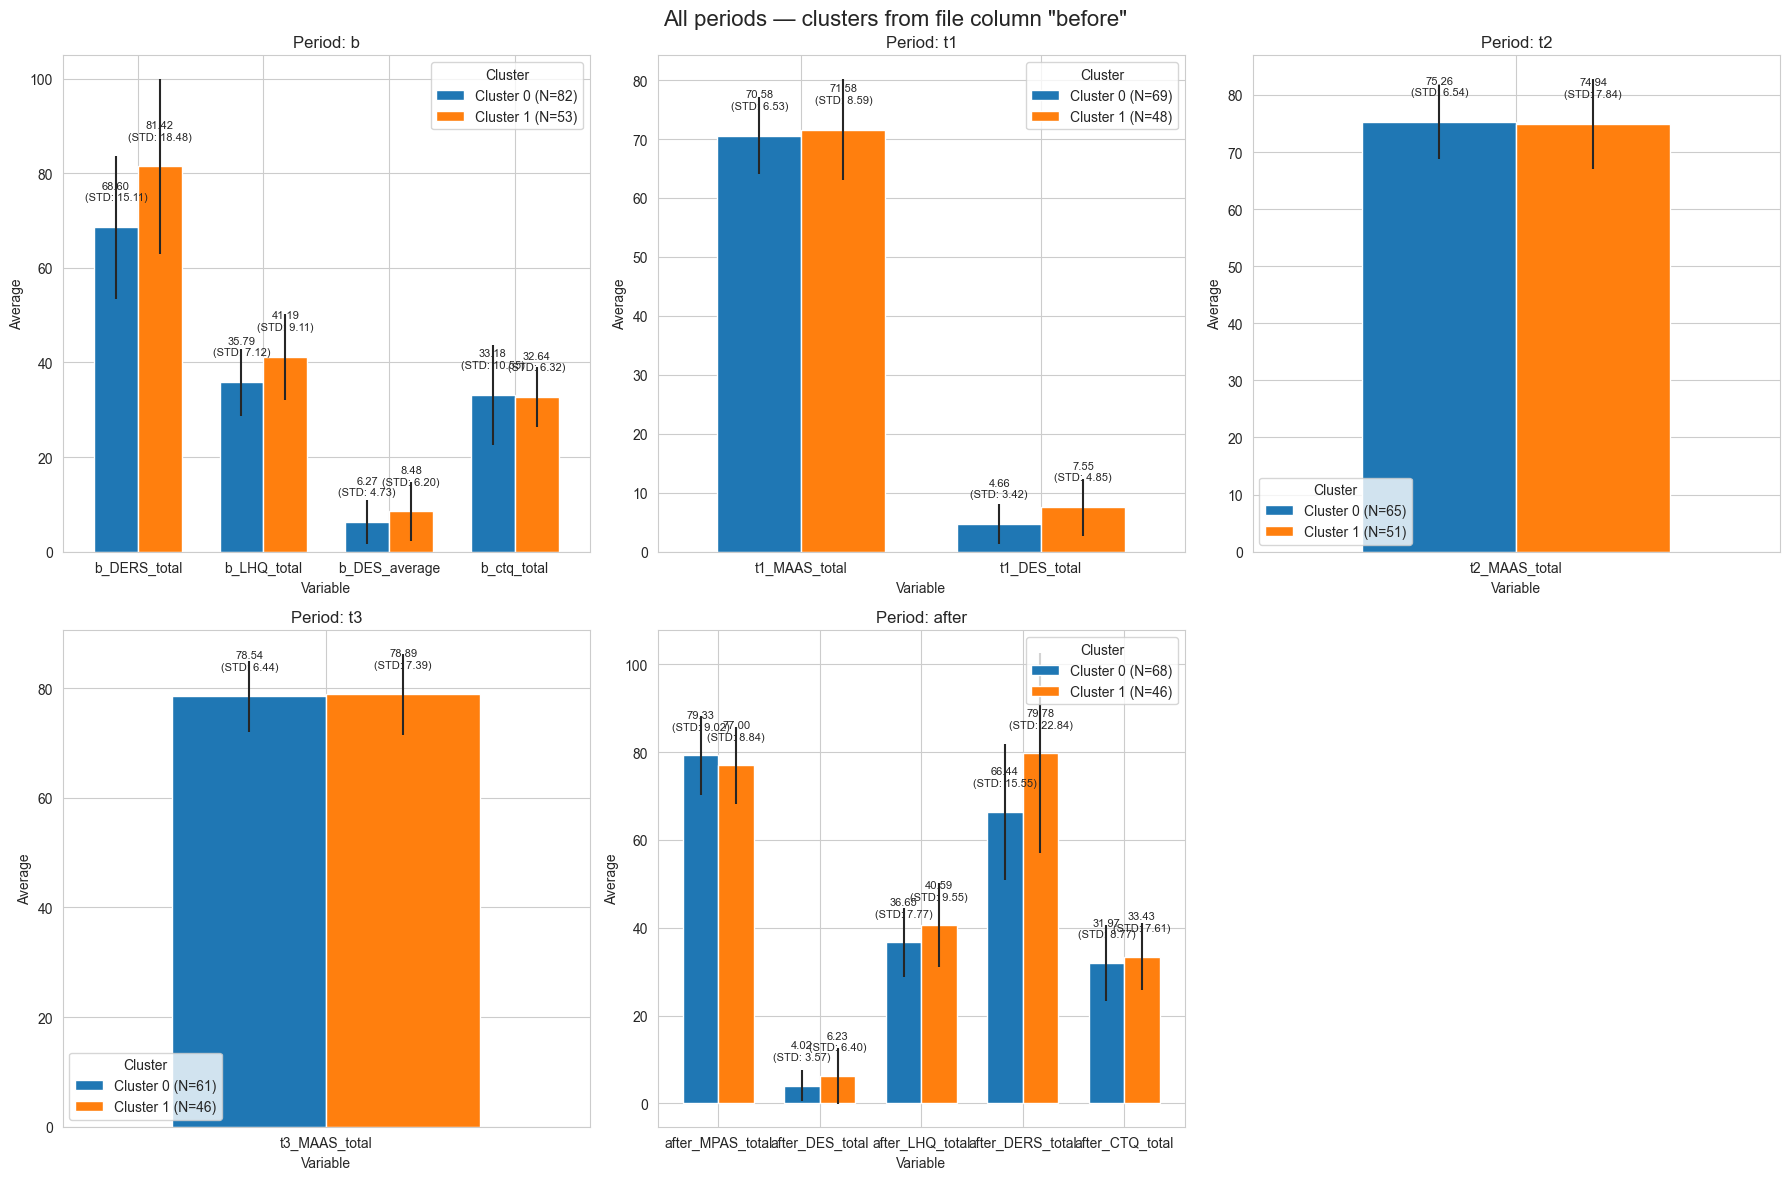

In [23]:
# === שימוש: גריד אחד לכל התקופות לפי התוויות מהקובץ ===
file_path = "data/only_Q_outputs/5_timepoints/filtered_merged_data.csv"
df = pd.read_csv(file_path)

# קחי את שם העמודה של התוויות כפי שהיא בקובץ (למשל 'before')
labels = get_labels_from_file(df, label_col='before')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, period_name in enumerate(periods.keys()):
    plot_one_period_with_labels(df, labels, period_name, axes[i],periods)

# מחיקת סאב-פלוט מיותר (המשבצת השישית)
for j in range(len(periods), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('All periods — clusters from file column "before"', fontsize=16)
plt.tight_layout()
plt.show()

In [24]:
# --- Settings ---
# Set this variable to True to apply FDR correction to all t-tests.
# If False, the tests will be performed without correction.
APPLY_FDR_CORRECTION = False

# Image-compatible colors (Cluster 0 dark, Cluster 1 light)
PALETTES = {
    'b': ['#2c6b7d', '#9bd3e0'],  # Dark/light turquoise
    't1': ['#7a4b1f', '#f4c9a5'],  # Dark/light brown
    't2': ['#215b2a', '#a3e3ac'],  # Dark/light green
    't3': ['#6b1e1e', '#f6b0b0'],  # Dark/light reddish
    'after': ['#3b2464', '#c7b6ee'],  # Dark/light purple
}

# If there are cluster label columns for each period in the file
USE_FILE_LABELS = True
LABEL_COL_PER_PERIOD = {
    'b': 'before',
    't1': 't1',
    't2': 't2',
    't3': 't3',
    'after': 'after',
}





In [25]:

# ========== Data Reading ==========
file_path = 'data/only_Q_outputs/5_timepoints/filtered_merged_data.csv'
df = pd.read_csv(file_path)

period_list = list(periods.keys())
n_periods = len(period_list)

# Prepare labels for each clustering row
labels_per_period = {}
for key in period_list:
    col = LABEL_COL_PER_PERIOD.get(key)
    if USE_FILE_LABELS and (col in df.columns):
        labels_per_period[key] = get_labels_from_file(df, col)
    else:
        raise ValueError(f"No label column found for period '{key}'. "
                         f"Update LABEL_COL_PER_PERIOD or disable USE_FILE_LABELS.")

# ============ Performing t-test and collecting data for tables ============
all_stats = []
all_t_test_results = []
all_p_values = []
p_val_map = []  # Map of indexes to link p-values to original results

for row_idx, cluster_period in enumerate(period_list):
    labels = labels_per_period[cluster_period]

    for col_idx, period_name in enumerate(period_list):
        cols = periods[period_name]
        block = df.loc[labels.index, cols].join(labels).dropna(subset=cols)
        if block.empty:
            continue

        counts = block['cluster'].value_counts().sort_index()
        num_clusters = len(counts)

        # Create a statistics table
        means = block.groupby('cluster')[cols].mean().sort_index()
        stds = block.groupby('cluster')[cols].std().sort_index()
        stats_df_result = pd.concat([means.stack().rename('mean'), stds.stack().rename('std')], axis=1)
        stats_df_result.index.names = ['cluster', 'variable']
        stats_df_result['N_in_cluster'] = stats_df_result.index.get_level_values('cluster').map(counts)
        stats_df_result['period_shown'] = period_name
        stats_df_result['clusters_from'] = cluster_period
        all_stats.append(stats_df_result)

        # Perform t-test and collect data
        if num_clusters >= 2:
            cluster_names = counts.index.tolist()
            for var in cols:
                group1 = block[block['cluster'] == cluster_names[0]][var].dropna()
                group2 = block[block['cluster'] == cluster_names[1]][var].dropna()

                if len(group1) > 1 and len(group2) > 1:
                    try:
                        t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit', equal_var=False)

                        result = {
                            'clusters_from_period': cluster_period,
                            'period_shown': period_name,
                            'variable': var,
                            't_statistic': t_stat,
                            'p_value': p_val,
                        }
                        all_t_test_results.append(result)
                        all_p_values.append(p_val)
                    except Exception as e:
                        print(f"An error occurred while performing the t-test for {var}: {e}")

t_test_df = pd.DataFrame(all_t_test_results)
if APPLY_FDR_CORRECTION and not t_test_df.empty:
    reject, pvals_corrected = fdrcorrection(t_test_df['p_value'])
    t_test_df['p_value_corrected'] = pvals_corrected
else:
    t_test_df['p_value_corrected'] = pd.NA


## cross between time points and clustering of time points

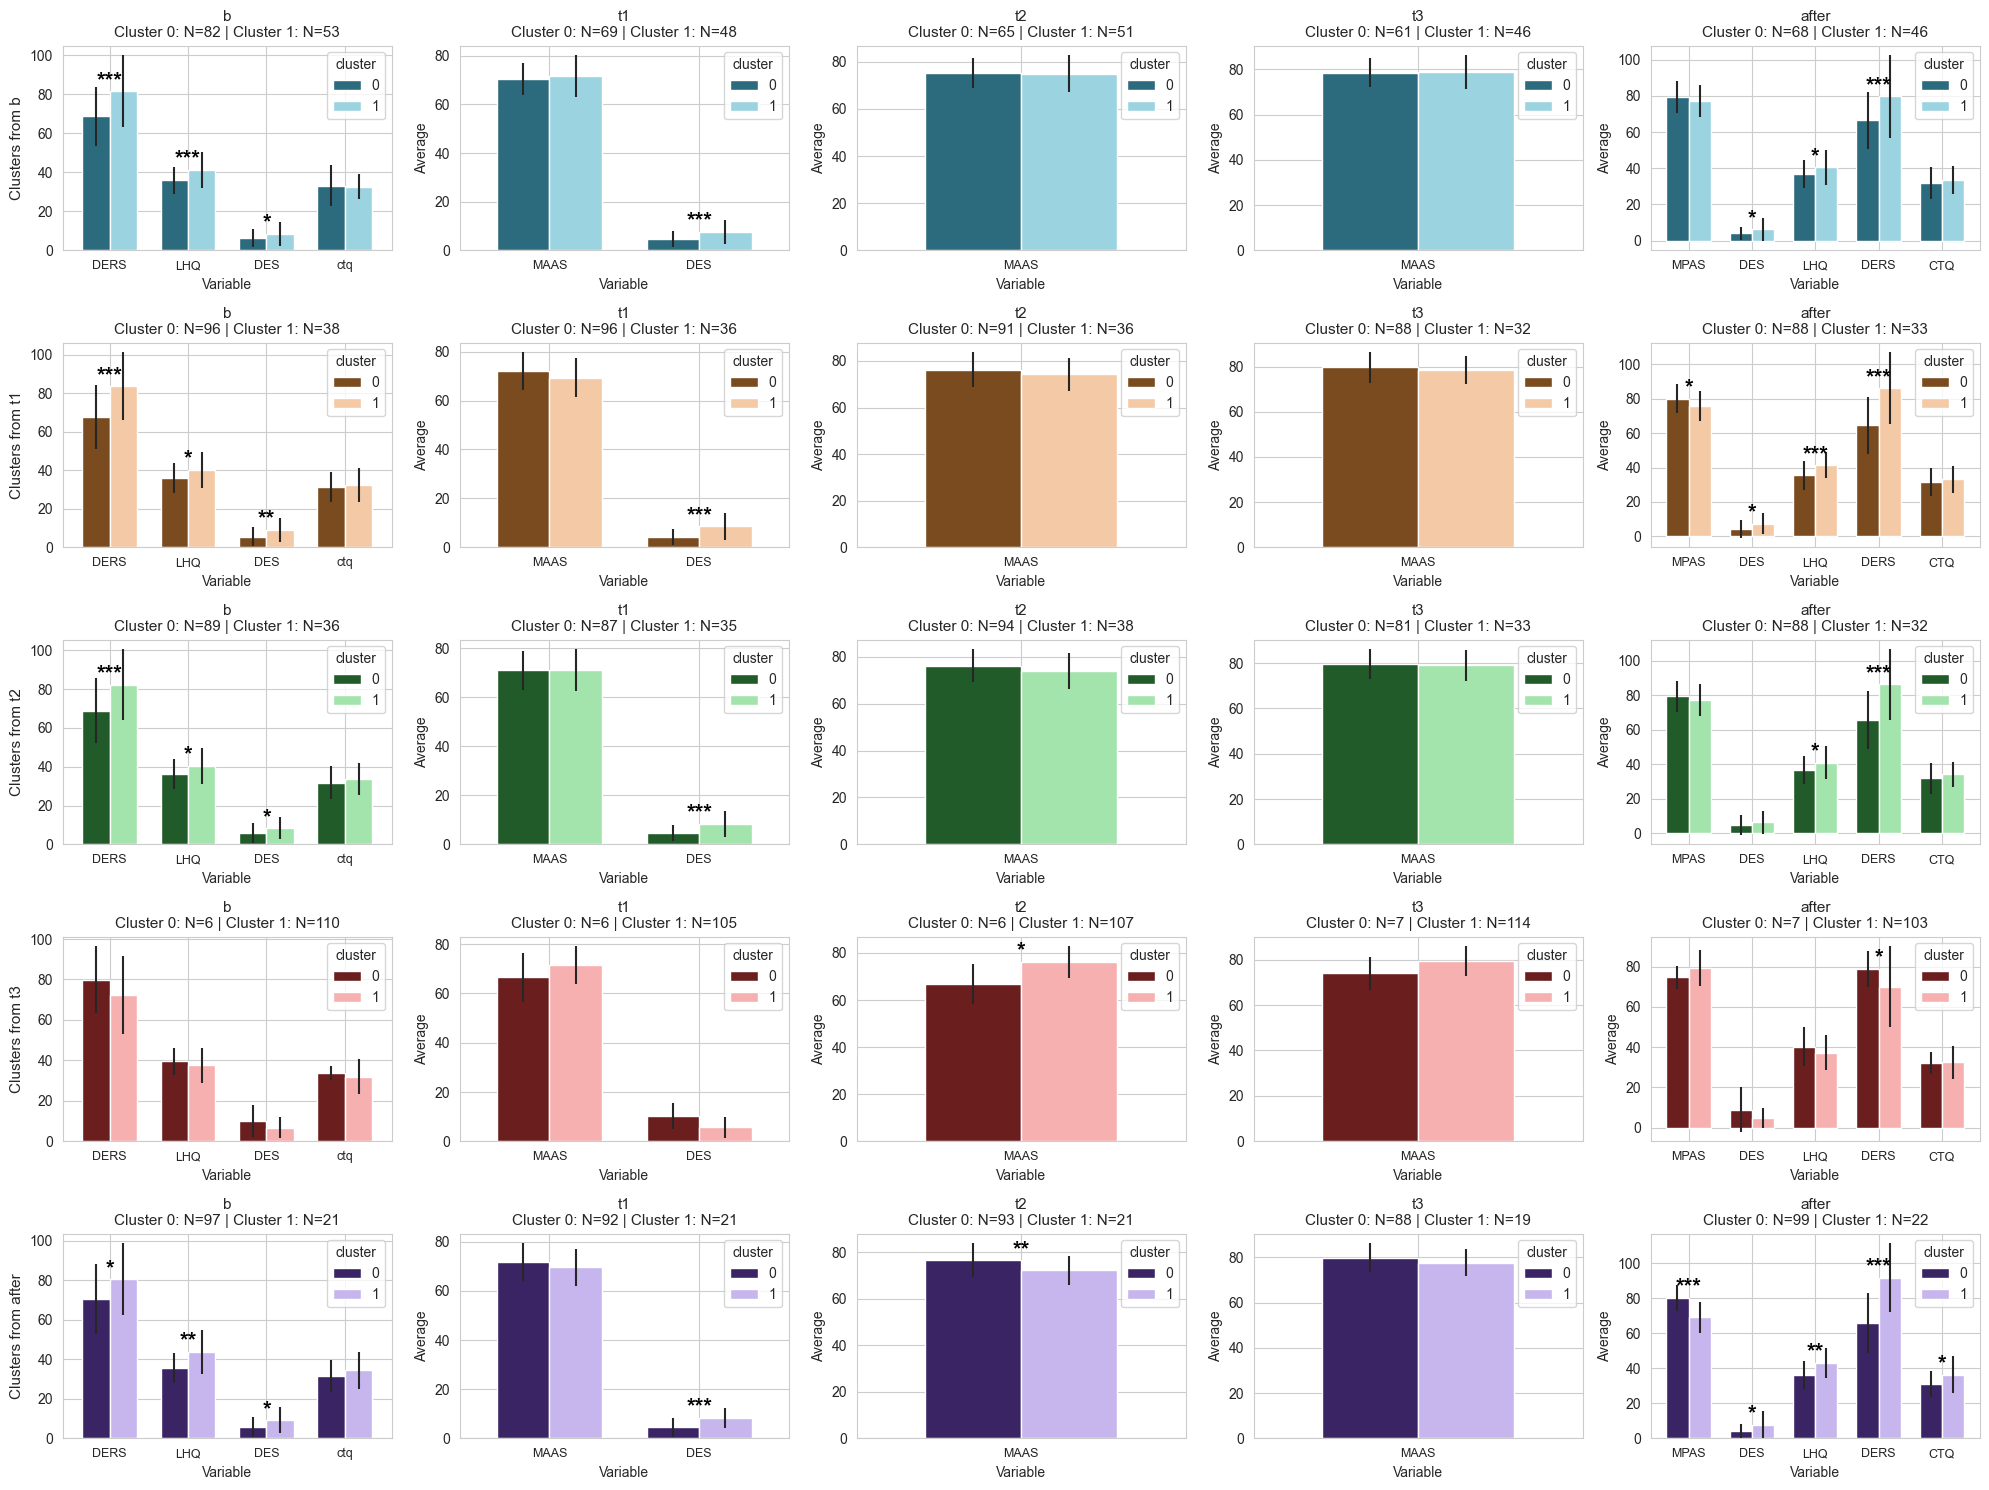

In [26]:

# ========== Drawing the grid and printing the statistics ==========
fig, axes = plt.subplots(n_periods, n_periods, figsize=(4 * n_periods, 3 * n_periods))
if n_periods == 1:
    axes = [[axes]]

for row_idx, cluster_period in enumerate(period_list):
    labels = labels_per_period[cluster_period]
    row_palette = PALETTES.get(cluster_period, ['#444444', '#bbbbbb'])

    for col_idx, period_name in enumerate(period_list):
        ax = axes[row_idx][col_idx]
        plot_one_period_with_labels_and_ttest(
            df, labels, period_name, ax,
            palette=row_palette,
            clusters_from_period=cluster_period,
            t_test_results_df=t_test_df,periods =periods)

    # Row label
    axes[row_idx][0].set_ylabel(f'Clusters from {cluster_period}', fontsize=11)

# === Shorten X labels in all graphs ===
for row in axes:
    for ax in row:
        ticks = ax.get_xticks()
        orig_labels = [t.get_text() for t in ax.get_xticklabels()]
        if not orig_labels:
            continue

        new_labels = []
        for lab in orig_labels:
            txt = lab.replace('\n', ' ').strip()
            tokens = [tok for tok in txt.split('_') if tok]
            if len(tokens) >= 3:
                core = " ".join(tokens[1:-1])
            elif len(tokens) == 2:
                core = tokens[1]
            else:
                parts = txt.split()
                core = parts[len(parts) // 2] if parts else ""
            new_labels.append(core)

        ax.set_xticks(ticks)
        ax.set_xticklabels(new_labels, rotation=0, ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [27]:
# ========= INPUTS =========
# A note on file paths: The script assumes your working directory is the same as the
# one where the script runs. If this is not the case, make sure the paths are absolute.
file_path = "data/only_Q_outputs/5_timepoints/filtered_merged_data_with_trajectory.csv"
out_dir = Path("data/only_Q_outputs/charts_configurable")
out_dir.mkdir(parents=True, exist_ok=True)

# ========= READ & BASIC CLEAN =========
base = pd.read_csv(file_path)
base.columns = [c.strip() for c in base.columns]
print(base.columns.tolist())
# (1) drop rows missing value in column #2 (second column in the file)
# If you meant a different column, change index 1 accordingly.
second_col = base.columns[1]
base = base[base[second_col].notna()].copy()

# (2) last column = label
label_col = base.columns[-1]

# normalize labels
labels_norm = (
    base[label_col]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"\s+", "_", regex=True)
)

# map variants -> canonical names
to_canonical = {
    "remain clinical": "remain clinical",
    "remain healthy": "remain healthy",
    "worsening": "worsening", # merge spelling
    "improving": "improving",
    "fluctuating": "fluctuating",
    "nan": None,              # literal "nan" strings
}

# The original line had a typo `to_ccanonical`, which has been fixed.
canon = labels_norm.map(lambda x: to_canonical.get(x, x))
base = base.assign(_group=canon)

# drop rows without a valid group (None/NaN)
base = base.dropna(subset=["_group"]).copy()

# (safety) also drop any literal "nan" that slipped through
base = base[base["_group"] != "nan"].copy()

# ========= SPLIT TO GROUPS =========
groups = {g: df.drop(columns=["_group"]).copy() for g, df in base.groupby("_group")}
# counts per group (number of subjects/rows)
group_counts = pd.Series({g: len(df) for g, df in groups.items()},
                         name="n_subjects").sort_index()
print("\nSubjects per group:")
print(group_counts)

# optional: save to CSV next to the charts
group_counts.to_csv(out_dir / "group_counts.csv", header=True)

# Expect these canonical groups; missing ones will just be absent
print("Groups:", list(groups.keys()))


['Subject_Code', 'b_ctq_total', 'b_LHQ_total', 'b_DES_average', 'b_DERS_total', 't1_MAAS_total', 't1_DES_total', 't2_MAAS_total', 't3_MAAS_total', 'b_PHQ_total', 'after_PHQ_total', 'b_GAD7_total', 'after_GAD7_total', 'after_MPAS_total', 'after_DES_total', 'after_LHQ_total', 'after_DERS_total', 'b_ctq_sexual_abuse', 'b_ctq_physical_abuse', 'b_ctq_emotional_abuse', 'b_ctq_physical_neglect', 'b_ctq_emotional_neglect', 'b_ctq_ABUSE', 'b_ctq_NEGLECT', 'b_DERS_Nonacceptance_Emotional_Responses', 'b_DERS_Goal_Directed_Behavior', 'b_DERS_Impulse_Control', 'b_DERS_Lack_Emotional_Awareness', 'b_DERS_Emotion_Regulation_Strategies', 'b_DERS_Lack_Emotional_Clarity', 'b_DES_Absorption', 'b_DES_Amnesia', 'b_DES_Depersonalization', 'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity', 'after_DES_Absorption', 'after_DES_Amne

In [28]:
# ============ Merging and printing the tables ============
if all_stats:
    stats_df = pd.concat(all_stats, axis=0)
    stats_df = stats_df[['period_shown', 'clusters_from', 'N_in_cluster', 'mean', 'std']]
    print("\n=== Averages and standard deviations for each cell in the grid ===")
    print(stats_df)

    stats_df.to_csv('data/only_Q_outputs/grid_cluster_stats.csv', index=True, encoding='utf-8-sig')

# ============ Merging and printing t-test results ============
if not t_test_df.empty:
    print(
        f"\n=== Two-sided t-test results {'with FDR correction' if APPLY_FDR_CORRECTION else 'without correction'} ===")
    print(t_test_df)

    t_test_df.to_csv('data/only_Q_outputs/5_timepoints/t_test_results_without_FDR.csv', index=False, encoding='utf-8-sig')




=== Averages and standard deviations for each cell in the grid ===
                         period_shown clusters_from  N_in_cluster       mean  \
cluster variable                                                               
0       b_DERS_total                b             b            82  68.597561   
        b_LHQ_total                 b             b            82  35.792683   
        b_DES_average               b             b            82   6.271777   
        b_ctq_total                 b             b            82  33.182927   
1       b_DERS_total                b             b            53  81.415094   
...                               ...           ...           ...        ...   
        after_MPAS_total        after         after            22  69.113636   
        after_DES_total         after         after            22   7.905844   
        after_LHQ_total         after         after            22  43.136364   
        after_DERS_total        after         after 

columns_to_select = ['b_ctq_total','b_LHQ_total', 'b_DES_average','b_DERS_total', 't1_MAAS_total','t1_DES_total','t2_MAAS_total','t3_MAAS_total'
,'after_MPAS_total','after_DES_total','after_LHQ_total','after_DERS_total',
        "b_ctq_sexual_abuse",
        "b_ctq_physical_abuse",
        "b_ctq_emotional_abuse",
        "b_ctq_physical_neglect",
        "b_ctq_emotional_neglect" ,
        "b_ctq_ABUSE  ",
        "b_ctq_NEGLECT",
        "b_DERS_Nonacceptance_Emotional_Responses",
        "b_DERS_Goal_Directed_Behavior",
        "b_DERS_Impulse_Control",
        "b_DERS_Lack_Emotional_Awareness",
        "b_DERS_Emotion_Regulation_Strategies",
        "b_DERS_Lack_Emotional_Clarity" ,
        "b_DES_Absorption ",
        "b_DES_Amnesia",
        "b_DES_Depersonalization ",
        "after_DERS_Nonacceptance_Emotional_Responses",
        "after_DERS_Goal_Directed_Behavior",
        "after_DERS_Impulse_Control",
        "after_DERS_Lack_Emotional_Awareness",
        "after_DERS_Emotion_Regulation_Strategies",
        "after_DERS_Lack_Emotional_Clarity" ,
        'after_DES_Absorption ',
        'after_DES_Amnesia',
        'after_DES_Depersonalization ','after_CTQ_total',
        "after_CTQ_sexual_abuse",
        "after_CTQ_physical_abuse",
        "after_CTQ_emotional_abuse",
        "after_CTQ_physical_neglect",
        "after_CTQ_emotional_neglect" ,
        "after_CTQ_ABUSE  ",
        "after_CTQ_NEGLECT"]

## t test between groups trajectory

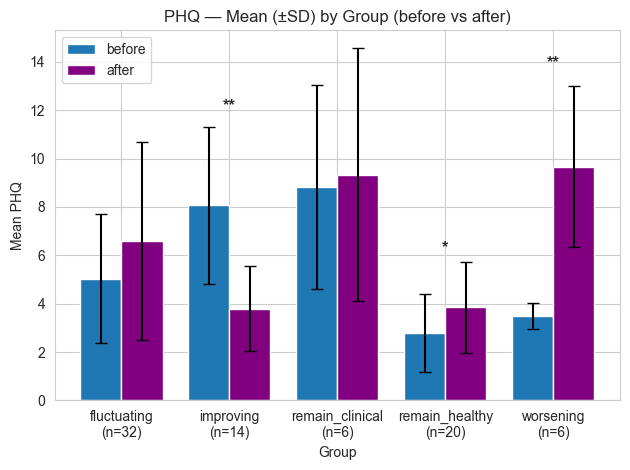

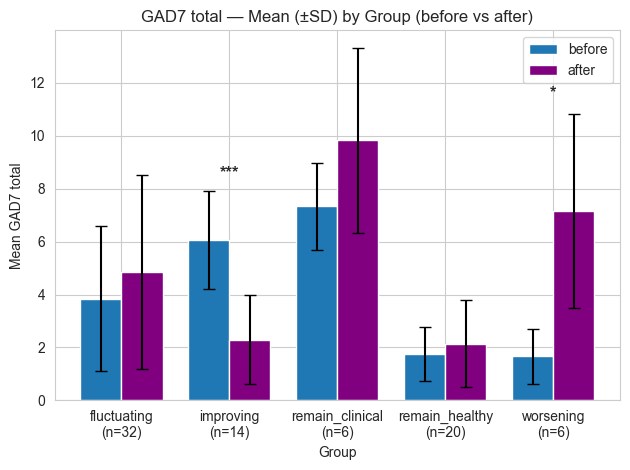

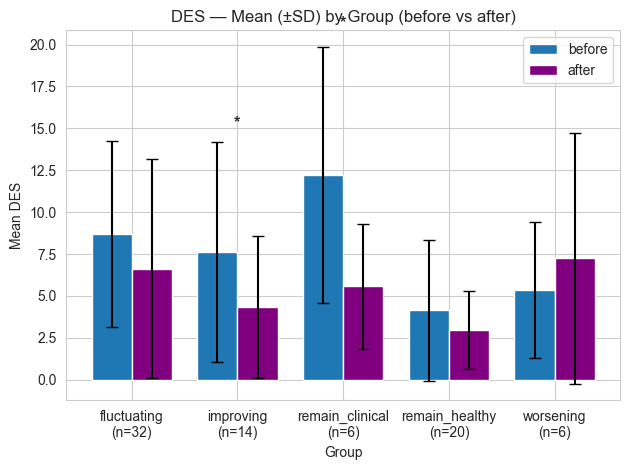

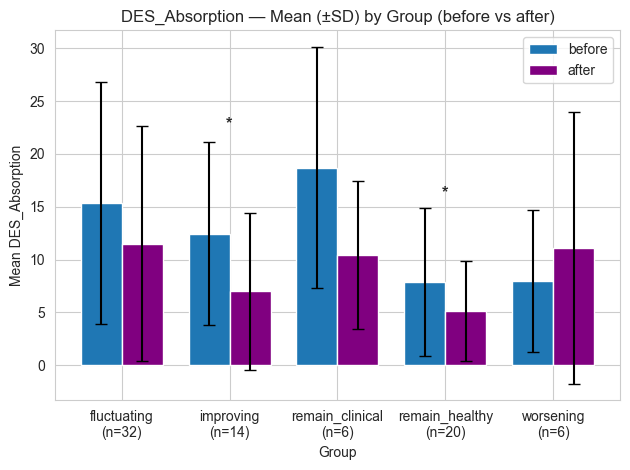

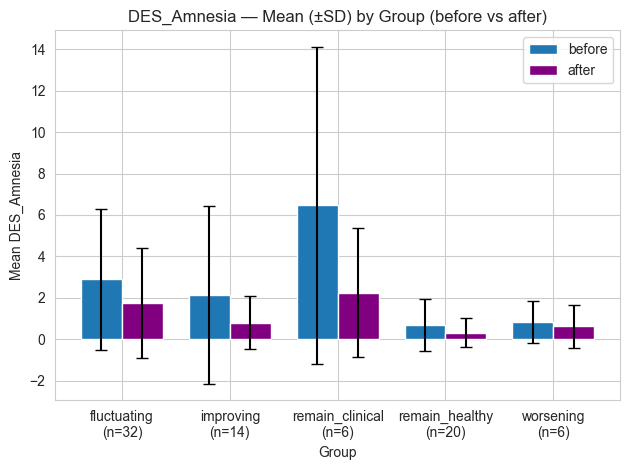

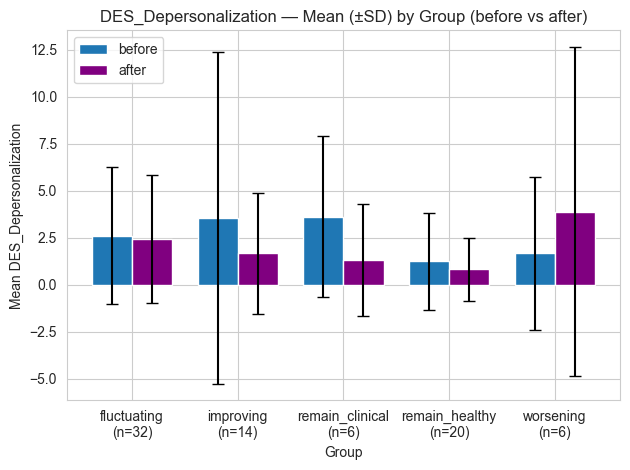

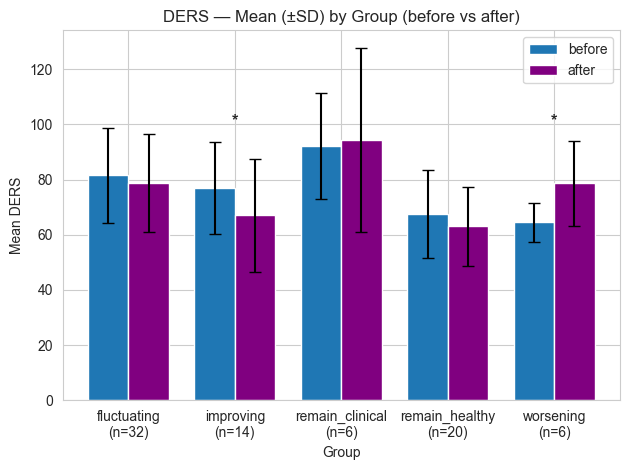

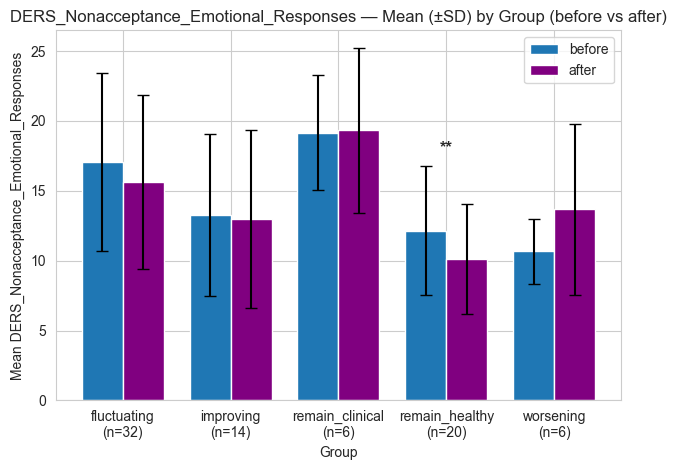

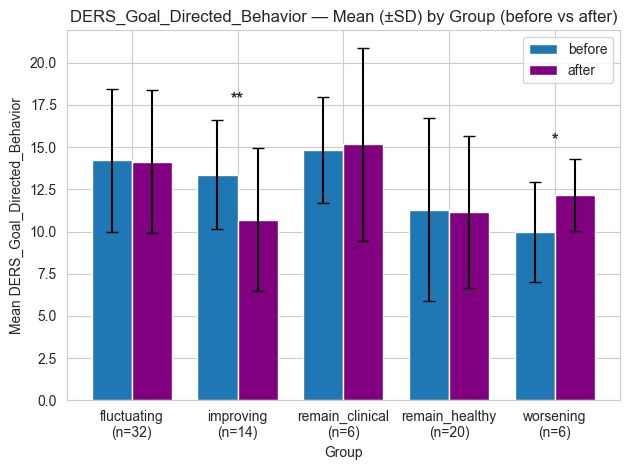

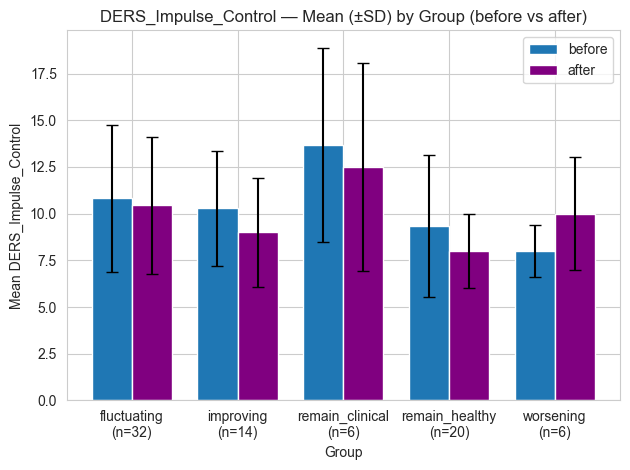

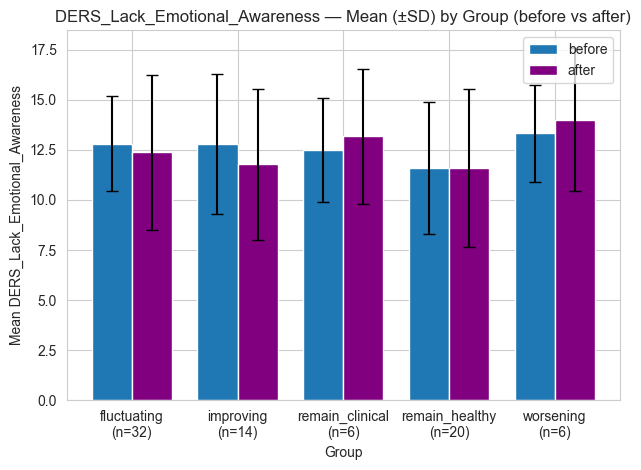

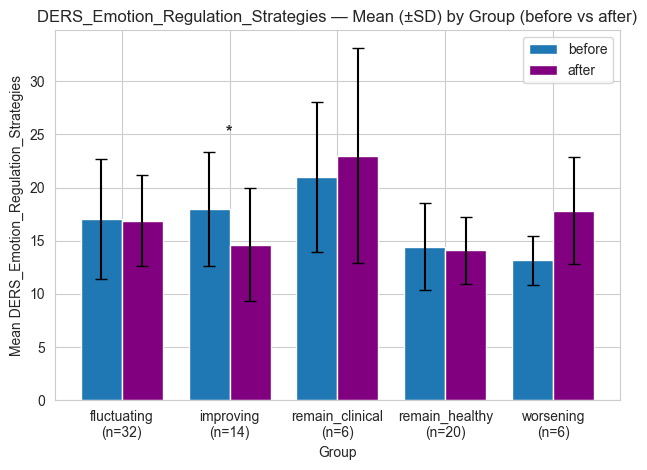

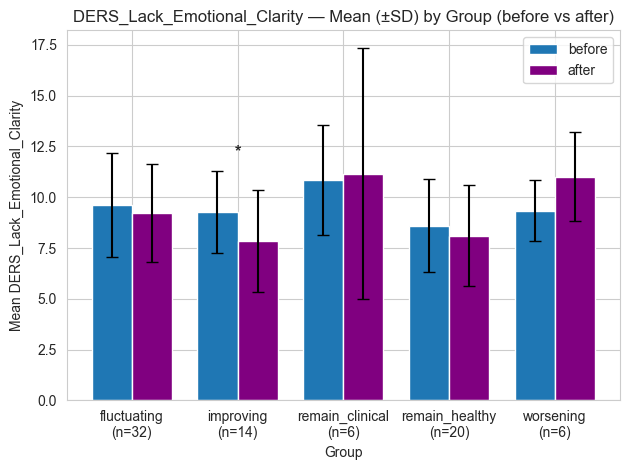

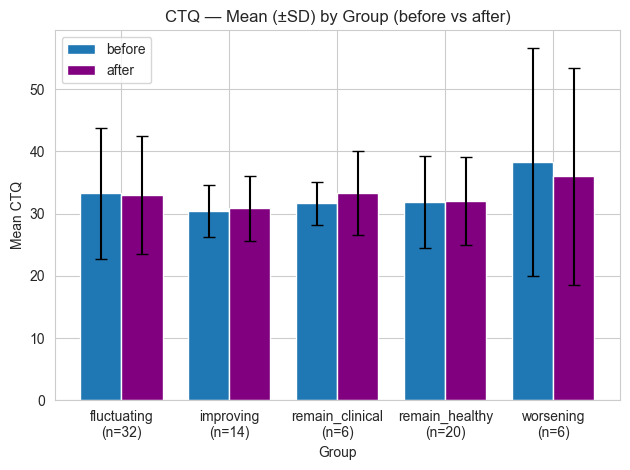

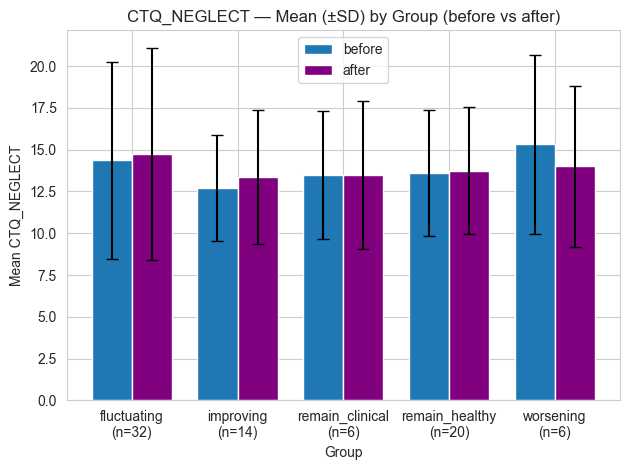

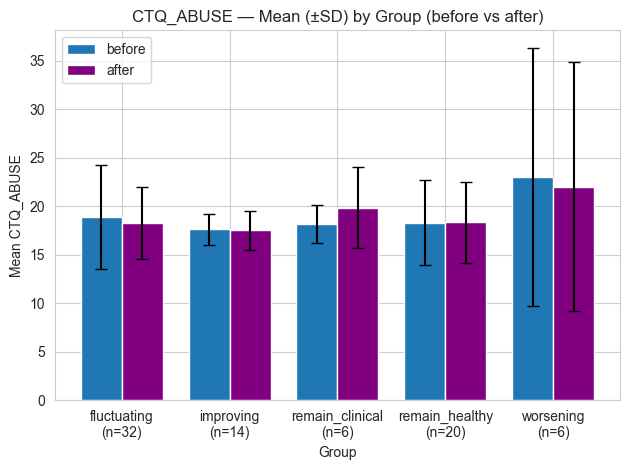

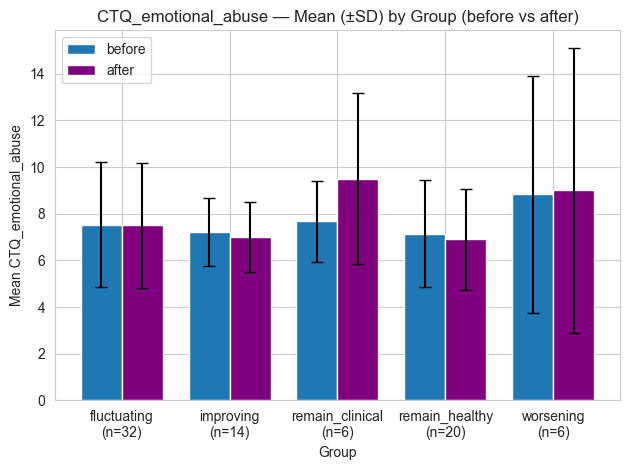

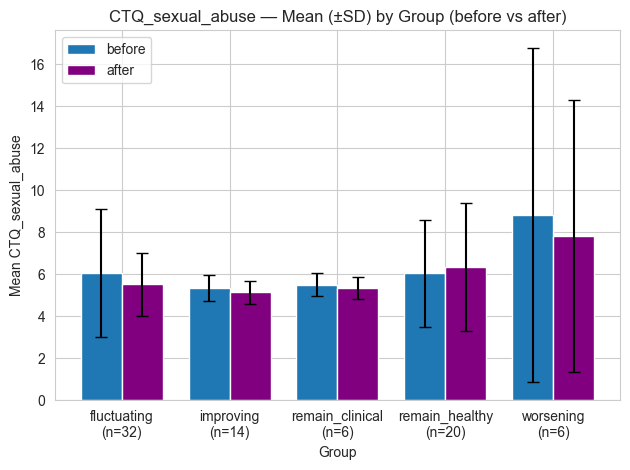

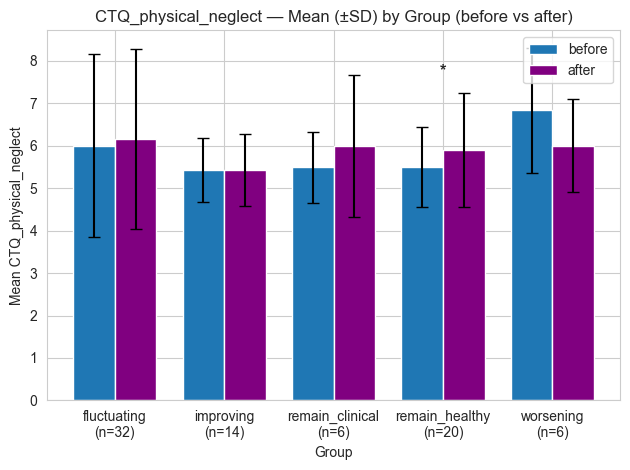

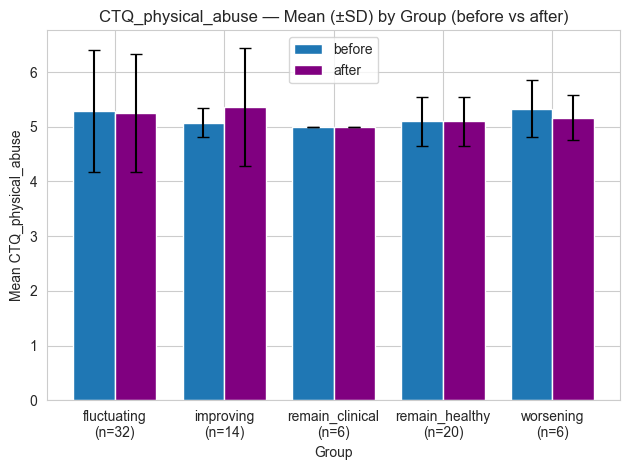

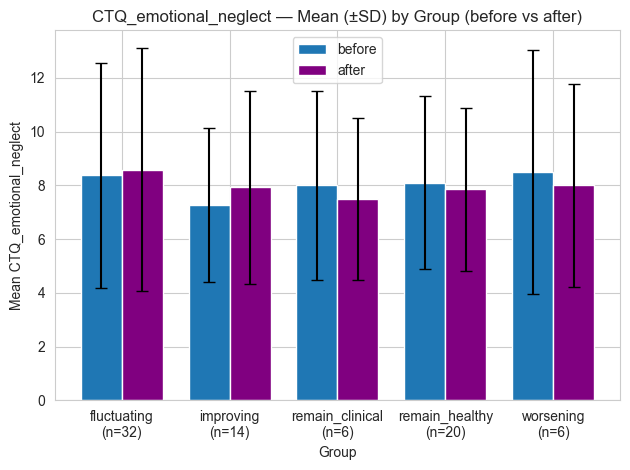

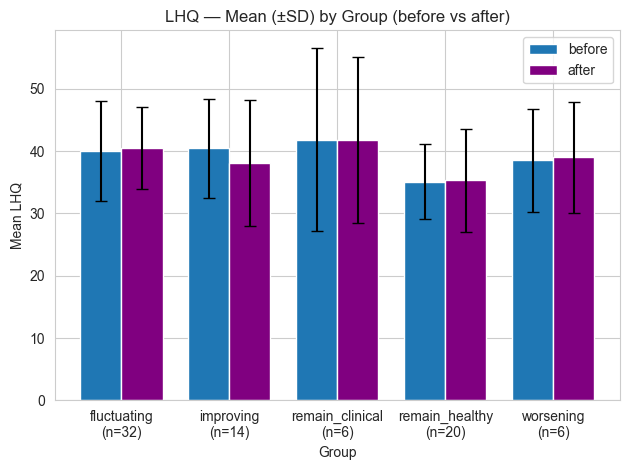

Charts saved to: data\only_Q_outputs\charts_configurable

Paired t-test results (before vs after):
    metric            group  mean_before  mean_after  std_before  std_after  \
0      PHQ      fluctuating     5.031250    6.593750    2.657726   4.094523   
1      PHQ        improving     8.071429    3.785714    3.245453   1.761930   
2      PHQ  remain_clinical     8.833333    9.333333    4.215052   5.240865   
3      PHQ   remain_healthy     2.800000    3.850000    1.609184   1.871532   
4      PHQ        worsening     3.500000    9.666667    0.547723   3.326660   
..     ...              ...          ...         ...         ...        ...   
105    LHQ      fluctuating    40.033333   40.833333    8.045060   5.988975   
106    LHQ        improving    40.428571   38.142857    7.910210  10.128840   
107    LHQ  remain_clinical    43.000000   41.800000   16.140012  13.367872   
108    LHQ   remain_healthy    35.100000   35.300000    6.007890   8.316755   
109    LHQ        worsening    3

In [29]:
from collections import defaultdict
#paired metrics with explicit before/after column names
paired_pairs = {
    "PHQ": ("b_PHQ_total", "after_PHQ_total"),
    "GAD7 total": ("b_GAD7_total", "after_GAD7_total"),
    "DES" : ('b_DES_average','after_DES_total'),
    "DES_Absorption" : ('b_DES_Absorption','after_DES_Absorption'),
    "DES_Amnesia" : ('b_DES_Amnesia','after_DES_Amnesia'),
    "DES_Depersonalization" : ('b_DES_Depersonalization','after_DES_Depersonalization'),
    "DERS" :('b_DERS_total','after_DERS_total'),
    "DERS_Nonacceptance_Emotional_Responses" :('b_DERS_Nonacceptance_Emotional_Responses','after_DERS_Nonacceptance_Emotional_Responses'),
    "DERS_Goal_Directed_Behavior" :('b_DERS_Goal_Directed_Behavior','after_DERS_Goal_Directed_Behavior'),
    "DERS_Impulse_Control" :('b_DERS_Impulse_Control','after_DERS_Impulse_Control'),
    "DERS_Lack_Emotional_Awareness" :('b_DERS_Lack_Emotional_Awareness','after_DERS_Lack_Emotional_Awareness'),
    "DERS_Emotion_Regulation_Strategies" :('b_DERS_Emotion_Regulation_Strategies','after_DERS_Emotion_Regulation_Strategies'),
    "DERS_Lack_Emotional_Clarity" :('b_DERS_Lack_Emotional_Clarity','after_DERS_Lack_Emotional_Clarity'),

    "CTQ" : ('b_ctq_total','after_CTQ_total'),
    "CTQ_NEGLECT" : ('b_ctq_NEGLECT','after_CTQ_NEGLECT'),
    "CTQ_ABUSE" : ('b_ctq_ABUSE','after_CTQ_ABUSE'),
    "CTQ_emotional_abuse" : ('b_ctq_emotional_abuse','after_CTQ_emotional_abuse'),
    "CTQ_sexual_abuse" : ('b_ctq_sexual_abuse','after_CTQ_sexual_abuse'),
    "CTQ_physical_neglect" : ('b_ctq_physical_neglect','after_CTQ_physical_neglect'),
    "CTQ_physical_abuse" : ('b_ctq_physical_abuse','after_CTQ_physical_abuse'),
    "CTQ_emotional_neglect" : ('b_ctq_emotional_neglect','after_CTQ_emotional_neglect'),
    "LHQ": ("b_LHQ_total", "after_LHQ_total"), }
def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# collect p-values per metric+group while you run the t-tests
pvals_by_metric = defaultdict(dict)

# ========= PAIRED (BEFORE/AFTER) CHARTS WITH ERROR BARS + T-TEST =========
ttest_results = []
all_paired_stats = []

for label, (b_col, a_col) in paired_pairs.items():
    if b_col not in base.columns or a_col not in base.columns:
        print(f"[warning] missing columns for '{label}' (expected: {b_col}, {a_col})")
        continue

    b_stats = stats_by_group(groups, b_col)
    a_stats = stats_by_group(groups, a_col)

    all_idx = sorted(set(b_stats.index) | set(a_stats.index))
    b_stats = b_stats.reindex(all_idx)
    a_stats = a_stats.reindex(all_idx)

    mask = ~(b_stats["mean"].isna() & a_stats["mean"].isna())
    b_stats = b_stats[mask]
    a_stats = a_stats[mask]

    if b_stats.empty and a_stats.empty:
        print(f"[info] no data to plot for '{label}'")
        continue

    # ---- run paired t-test per group and collect all stats (and p-values for stars) ----
    for gname, gdf in groups.items():
        if b_col in gdf.columns and a_col in gdf.columns:
            paired = gdf[[b_col, a_col]].dropna()
            if not paired.empty:
                stat, pval = ttest_rel(paired[b_col], paired[a_col])
                pvals_by_metric[label][gname] = pval  # <-- save for stars

                mean_b = paired[b_col].mean()
                mean_a = paired[a_col].mean()
                std_b  = paired[b_col].std(ddof=1)
                std_a  = paired[a_col].std(ddof=1)
                diff   = mean_b - mean_a

                all_paired_stats.append({
                    "metric": label,
                    "group": gname,
                    "mean_before": mean_b,
                    "mean_after": mean_a,
                    "std_before": std_b,
                    "std_after": std_a,
                    "diff_(before-after)": diff,
                    "t_value": stat,
                    "p_value": pval,
                    "n": len(paired)
                })

    # ===== plotting (and annotating stars) =====
    x = np.arange(len(b_stats.index))
    width = 0.38

    fig, ax = plt.subplots()
    bars_before = ax.bar(x - width/2, b_stats["mean"].values, width,
                         yerr=b_stats["std"].values, capsize=4, label="before")
    bars_after  = ax.bar(x + width/2, a_stats["mean"].values, width,
                         yerr=a_stats["std"].values, capsize=4, label="after", color="purple")

    ax.set_title(f"{label} — Mean (±SD) by Group (before vs after)")
    ax.set_xlabel("Group")
    ax.set_ylabel(f"Mean {label}")
    xtick_labels = [f"{g}\n(n={group_counts.get(g, 0)})" for g in b_stats.index]
    ax.set_xticks(x, xtick_labels)
    ax.legend()
    fig.tight_layout()

    # ---- add significance asterisks per group ----
    # position stars a little above the taller bar + its error bar
    for i, gname in enumerate(b_stats.index):
        pval = pvals_by_metric[label].get(gname, None)
        stars = p_to_stars(pval) if pval is not None else ''
        if not stars:
            continue

        mean_b = b_stats.loc[gname, "mean"]
        std_b  = b_stats.loc[gname, "std"]
        mean_a = a_stats.loc[gname, "mean"]
        std_a  = a_stats.loc[gname, "std"]

        # bar tops including error bars
        top_b = (mean_b if pd.notna(mean_b) else 0.0) + (std_b if pd.notna(std_b) else 0.0)
        top_a = (mean_a if pd.notna(mean_a) else 0.0) + (std_a if pd.notna(std_a) else 0.0)
        y_max = max(top_b, top_a)

        x_b = i - width/2
        x_a = i + width/2
        y_star = y_max * 1.05 if y_max > 0 else 0.05  # simple offset; tweak if needed

        # add the stars centered between the bars
        ax.text((x_b + x_a) / 2, y_star, stars, ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.savefig(out_dir / f"{safe(label)}_before_vs_after_by_group.png", dpi=150)
    plt.show()

# ========= SAVE FINAL STATS TO CSV =========
print(f"Charts saved to: {out_dir}")

if all_paired_stats:
    paired_df = pd.DataFrame(all_paired_stats)
    paired_df['t_value'] = paired_df['t_value'].round(3)
    paired_df['p_value'] = paired_df['p_value'].round(4)
    print("\nPaired t-test results (before vs after):")
    print(paired_df)
    paired_df.to_csv(out_dir / "paired_stats_report.csv", index=False)


## 6 extreme groups trajectory

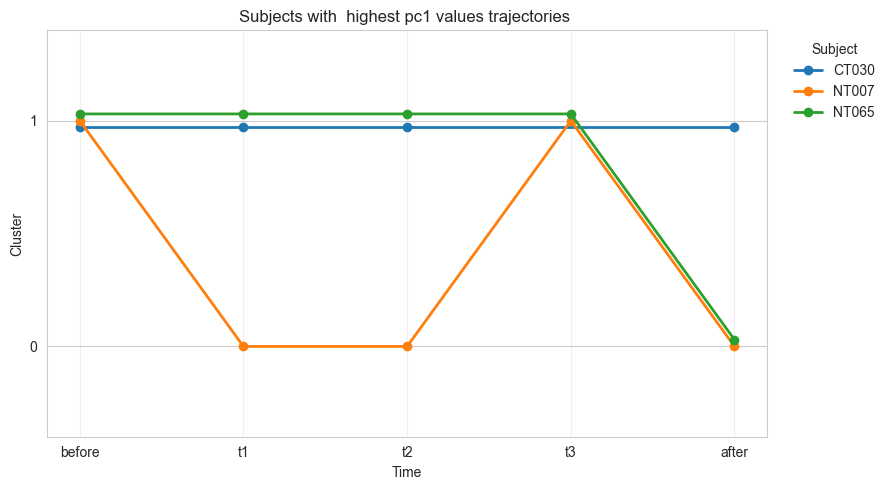

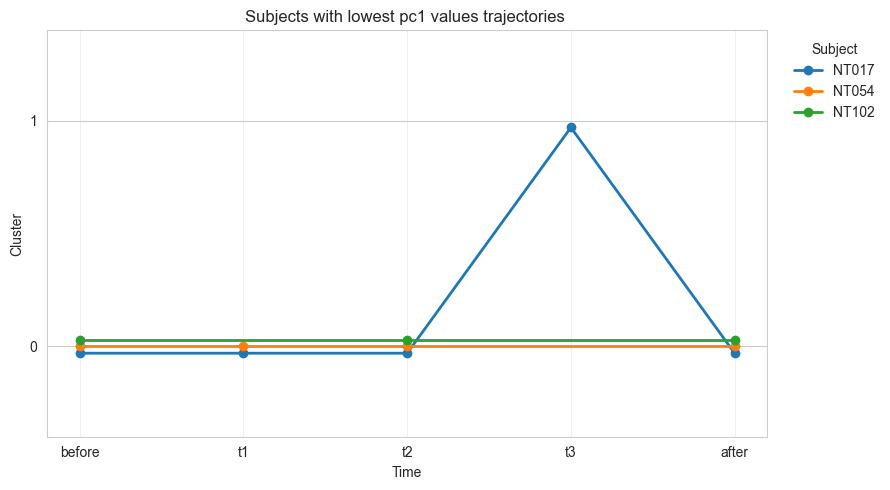

In [30]:

out_before_after = transition_for_pair(
    csv_path="data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv",
    from_period="before",   # <-- you type this
    to_period="after",  # <-- and this
    out_dir="data/only_Q_outputs/5_timepoints/out",
    save_prefix=None,
    annotate=True
)

out_t1_after = transition_for_pair(
    csv_path="data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv",
    from_period="t1",  # <-- you type this
    to_period="after",  # <-- and this
    out_dir="data/only_Q_outputs/5_timepoints/out",
    save_prefix=None,
    annotate=True
)

out_t2_after = transition_for_pair(
    csv_path="data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv",
    from_period="t2",  # <-- you type this
    to_period="after",  # <-- and this
    out_dir="data/only_Q_outputs/5_timepoints/out",
    save_prefix=None,
    annotate=True
)

out_t3_after = transition_for_pair(
    csv_path="data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv",
    from_period="t3",  # <-- you type this
    to_period="after",  # <-- and this
    out_dir="data/only_Q_outputs/5_timepoints/out",
    save_prefix=None,
    annotate=True
)




# Example: pick your 6 subjects
subjects = ["CT030", "NT007", "NT065"]
plot_subject_trajectories("data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv", subjects,title = "Subjects with  highest pc1 values trajectories ")

# Example: pick your 6 subjects
subjects = ["NT017", "NT054", "NT102"]
plot_subject_trajectories("data/only_Q_outputs/5_timepoints/merged_file_inverted_2.csv", subjects ,title =  "Subjects with lowest pc1 values trajectories ")
